In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.time import Time 
from astropy.stats import sigma_clip
pd.set_option('display.max_columns', 500)
from collections import OrderedDict

The data in the below directory come from https://lsst-web.ncsa.illinois.edu/~yusra/S13Agg/   , and they come from NCSA 
    
The other catalog : https://lsst-web.ncsa.illinois.edu/~yusra/S13_IN2P3_lightcurve_metrics/    has IN2P3 data 
        
        

In [2]:
DirIn =  '/astro/store/scratch/tmp/suberlak/S13Agg/' #'/astro/users/suberlak/S13Agg/'


## Detection Data ,  Extendedness 

In [3]:
# Star-Galaxy separation is stored  in two files  : iCoaddPhotometryAll.csv , and DeepSourceNCSA_i_lt300.csv

# The first one (below) stores information about each i-band detected source, and its relationship
# to surrounding objects.  If it is a combined source, with eg. star right next to the galaxy, 
# they all get the same parentDeepSourceId,  and each component gets individual deepSourceId
# If parentDeepSourceId is NaN,  it means that the deepSource is a parent (or is not a combined source).

# the deepSourceId  is the same as objectId  elsewhere  (they match)


# Use iPsfMag - iModelMag as extendedness    
    
coadd_data = pd.read_csv(DirIn+'iCoaddPhotometryAll.csv', nrows=2000000)
coadd_data.head()

,deepSourceId,parentDeepSourceId,ra,decl,iPsfMag,iPsfMagSigma,iModelMag,iModelMagSigma,flagNegative,flagBadMeasCentroid,flagPixEdge,flagPixInterpAny,flagPixInterpCen,flagPixSaturAny,flagPixSaturCen,flagBadPsfFlux,flagBadApFlux,flagBadModelFlux,flagBadInstFlux,flagBadCentroid,flagBadShape,coadd_id,tract,patchX,patchY
0,217773674667705145,NaN,319.919107,-0.629259,19.336573,0.013132,19.271638,0.013089,0,0,0,1,0,0,0,0,0,0,0,0,0,1622540315,3,182,3
1,217773674667705152,NaN,320.016077,-0.629022,24.260910,0.306782,24.106004,0.266067,0,0,0,0,0,0,0,0,0,0,0,0,1,1622540315,3,182,3
2,217773674667705153,NaN,319.995803,-0.628850,23.652247,0.178502,23.507118,0.156290,0,0,0,1,0,0,0,0,0,0,0,0,0,1622540315,3,182,3
3,217773674667705154,NaN,319.873218,-0.628994,23.651222,0.162873,23.606465,0.156336,0,0,0,0,0,0,0,0,0,0,0,0,0,1622540315,3,182,3
4,217773674667705155,NaN,320.027201,-0.629010,24.330852,0.296112,24.307682,0.289872,0,0,0,0,0,0,0,0,0,0,0,0,0,1622540315,3,182,3


In [30]:
# Initialize all with zeros, and those that are bigger than the threshold, become 1 
coadd_data['extendedness'] = 0
coadd_data.ix[coadd_data['iPsfMag'] - coadd_data['iModelMag'] > 0.085645, 'extendedness'] = 1 

In [39]:

coadd_data.columns

Index([u'deepSourceId', u'parentDeepSourceId', u'ra', u'decl', u'iPsfMag',
       u'iPsfMagSigma', u'iModelMag', u'iModelMagSigma', u'flagNegative',
       u'flagBadMeasCentroid', u'flagPixEdge', u'flagPixInterpAny',
       u'flagPixInterpCen', u'flagPixSaturAny', u'flagPixSaturCen',
       u'flagBadPsfFlux', u'flagBadApFlux', u'flagBadModelFlux',
       u'flagBadInstFlux', u'flagBadCentroid', u'flagBadShape', u'coadd_id',
       u'tract', u'patchX', u'patchY', u'extendedness'],
      dtype='object')

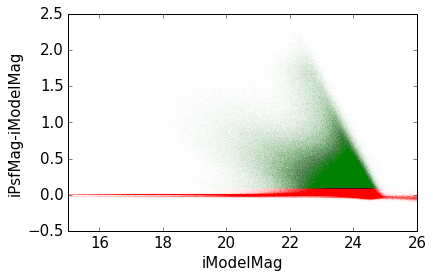

In [37]:
# Print iPsfMag   vs    iPsfMag - iModelMag  ,  and color by extendness 
%matplotlib inline
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green'])
plt.ylabel('iPsfMag-iModelMag', fontsize=15)
plt.xlabel('iModelMag', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.xlim(15,26)
plt.ylim(-0.5,2.5)
plt.scatter(coadd_data['iModelMag'],  coadd_data['iPsfMag']-coadd_data['iModelMag'], s=0.01, c=coadd_data['extendedness'], cmap=cmap,lw = 0)
plt.savefig('Extendedness_1628567_srcs.png')
plt.show()

In [126]:
#coadd_data['iPsfMag']-coadd_data['iModelMag']

In [4]:
# The second Star-Galaxy separation file is DeepSourceNCSA_i_lt300.csv , 

# It's very similar to iCoaddPhotometryAll.csv , but it also contains   a column  detect_is_primary, 
# which is True  (1) if the source is a primary source in a crowded field.  

deep_src = pd.read_csv(DirIn+'DeepSourceNCSA_i_lt300.csv', nrows=2000000)

In [115]:
len(coadd_data.columns)

25

In [123]:
np.array(deep_src.columns)[~np.in1d(np.array(deep_src.columns), np.array(coadd_data.columns))]

array(['deepCoaddId', 'filterId', 'raVar', 'declVar', 'radeclCov', 'x',
       'y', 'xVar', 'yVar', 'xyCov', 'psfFlux', 'psfFluxSigma', 'apFlux',
       'apFluxSigma', 'modelFlux', 'modelFluxSigma', 'instFlux',
       'instFluxSigma', 'apCorrection', 'shapeIx', 'shapeIy', 'shapeIxVar',
       'shapeIyVar', 'shapeIxIyCov', 'shapeIxx', 'shapeIyy', 'shapeIxy',
       'shapeIxxVar', 'shapeIyyVar', 'shapeIxyVar', 'shapeIxxIyyCov',
       'shapeIxxIxyCov', 'shapeIyyIxyCov', 'extendedness',
       'detect_is_primary', 'patch', 'fluxMag0', 'fluxMag0Sigma',
       'psfFluxCal', 'psfFluxCalSigma', 'psfMag', 'psfMagSigma'], dtype=object)

In [129]:
deep_src.head()

,deepSourceId,parentDeepSourceId,deepCoaddId,filterId,ra,decl,raVar,declVar,radeclCov,x,y,xVar,yVar,xyCov,psfFlux,psfFluxSigma,apFlux,apFluxSigma,modelFlux,modelFluxSigma,instFlux,instFluxSigma,apCorrection,shapeIx,shapeIy,shapeIxVar,shapeIyVar,shapeIxIyCov,shapeIxx,shapeIyy,shapeIxy,shapeIxxVar,shapeIyyVar,shapeIxyVar,shapeIxxIyyCov,shapeIxxIxyCov,shapeIyyIxyCov,extendedness,flagNegative,flagBadMeasCentroid,flagPixEdge,flagPixInterpAny,flagPixInterpCen,flagPixSaturAny,flagPixSaturCen,flagBadPsfFlux,flagBadApFlux,flagBadModelFlux,flagBadInstFlux,flagBadCentroid,flagBadShape,detect_is_primary,tract,patch,fluxMag0,fluxMag0Sigma,psfFluxCal,psfFluxCalSigma,psfMag,psfMagSigma
0,217773674667705111,-1,1622540315,3,319.950880,-0.630753,NaN,NaN,NaN,364991.000000,5707.00000,NaN,NaN,NaN,147.830804,3.273722,253.297094,7.787514,NaN,NaN,302.941161,8.211800,1.000491,1020.841911,16.214718,NaN,NaN,NaN,5.897490,4.648105,-3.191148,0.102224,0.055249,0.063500,NaN,NaN,NaN,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,3,"182,3",6.267228e+10,7.356702e+08,8.564252e-29,2.146525e-30,21.568276,0.027213
1,217773674667705112,-1,1622540315,3,319.909737,-0.630563,0.000362,0.000342,-3.819975e-11,365365.026818,5708.72229,0.002306,0.002178,NaN,134.057514,3.259060,128.282589,7.805651,NaN,NaN,129.440189,4.525211,1.000441,1395.030126,17.727483,NaN,NaN,NaN,1.258127,1.273731,0.018527,0.007738,0.003918,0.007931,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,3,"182,3",6.267228e+10,7.356702e+08,7.766327e-29,2.096634e-30,21.674461,0.029311
2,217773674667705113,-1,1622540315,3,319.983550,-0.630753,NaN,NaN,NaN,364694.000000,5707.00000,NaN,NaN,NaN,10465.344501,7.535255,10502.450161,9.552545,NaN,NaN,10995.869671,13.218507,1.000477,723.842121,16.216850,NaN,NaN,NaN,1.522029,1.530062,-0.145890,0.000013,0.000007,0.000014,NaN,NaN,NaN,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,3,"182,3",6.267228e+10,7.356702e+08,6.062867e-27,7.130192e-29,16.943305,0.012769
3,217773674667705117,-1,1622540315,3,319.947250,-0.630753,NaN,NaN,NaN,365024.000000,5707.00000,NaN,NaN,NaN,247.478435,3.326350,440.775268,7.819879,NaN,NaN,530.848685,8.924627,1.000482,1053.974235,15.937370,NaN,NaN,NaN,5.913158,4.195268,1.622311,0.039531,0.015511,0.019898,NaN,NaN,NaN,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,3,"182,3",6.267228e+10,7.356702e+08,1.433712e-28,2.558478e-30,21.008845,0.019375
4,217773674667705124,-1,1622540315,3,319.885980,-0.630643,NaN,NaN,NaN,365581.000000,5708.00000,NaN,NaN,NaN,589.652812,3.508503,1117.006193,7.994964,NaN,NaN,1197.400592,9.551433,1.000515,1611.017230,16.859080,NaN,NaN,NaN,4.785268,4.454724,0.637503,0.005828,0.002765,0.005051,NaN,NaN,NaN,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,3,"182,3",6.267228e+10,7.356702e+08,3.416024e-28,4.495585e-30,20.066198,0.014289


In [125]:
# Merge  iCoaddPhotometryAll.csv (iPsfMag ,  iModelMag)  with  DeepSourceNCSA_i_lt300.csv (extendedness).   
#   on   deepSourceId
# Find what is the best separation parameter 

In [5]:
len(np.unique(coadd_data['deepSourceId'].values))

2000000

In [206]:
# Those objects from the coadd_data that have a match with the deep_src  given first 200000 rows from both files 
# to check the code (in theory for full files the overlap is complete, but I don't have  enough memory right now )

np.sum(np.in1d(coadd_data['deepSourceId'].values, deep_src['deepSourceId'].values))

1628567

In [6]:
# Merge the iPsf - iModel    and  extendedness information for the plot .... 
coadd_merged = pd.merge(coadd_data, deep_src, how='left', on='deepSourceId', suffixes=('_x', '_y'), copy=True, indicator=False)


In [9]:
# Ok, so we found extendedness for each of the sources that got matched...
len(coadd_merged['extendedness'].dropna().values)

1628567

In [7]:
np.unique(coadd_merged['extendedness'].dropna().values)

array([ 0.,  1.])

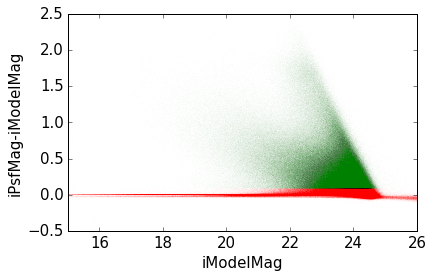

In [8]:
# Print iPsfMag   vs    iPsfMag - iModelMag  ,  and color by extendness 
%matplotlib inline
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green'])
iPsf = coadd_merged['iPsfMag']
iModel = coadd_merged['iModelMag']
plt.ylabel('iPsfMag-iModelMag', fontsize=15)
plt.xlabel('iModelMag', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.xlim(15,26)
plt.ylim(-0.5,2.5)
plt.scatter(iModel,  iPsf-iModel, s=0.01, c=coadd_merged['extendedness'], cmap=cmap,lw = 0)
plt.savefig('Extendedness_1628567_srcs.png')
plt.show()

472751

In [26]:

# Maximum value of the  iPsf - iModel   for compact sources   is the cutoff value 
msk = coadd_merged['extendedness'] == 0
diff = iPsf[msk]-iModel[msk]
max(diff.values)

0.084645219604293942

In [27]:

# Minimum value of the  iPsf - iModel   for extended sources   is the cutoff value 
msk = coadd_merged['extendedness'] == 1
diff = iPsf[msk]-iModel[msk]
min(diff.values)

0.084646660124388262

In [263]:
mask_x = (iModel > 16) & (iModel < 25)

In [264]:
mask_y = ((iPsf-iModel) < 2.5) & ((iPsf-iModel) > -0.5)

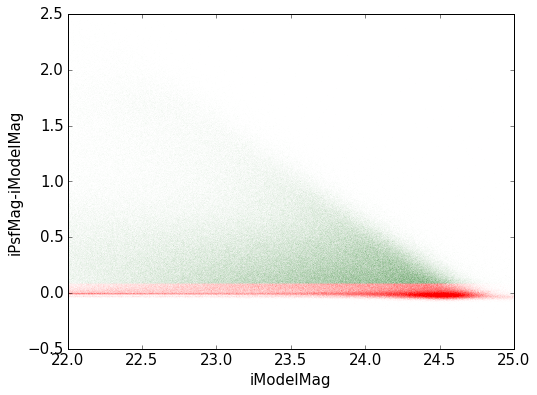

In [313]:
iPsf = coadd_merged['iPsfMag']
iModel = coadd_merged['iModelMag']
color = coadd_merged['extendedness']
# limit before plotting 
xlim = [22,25]
ylim = [-0.5,2.5]
mask_x = (iModel > xlim[0]) & (iModel < xlim[1])
mask_y = ((iPsf-iModel) < ylim[1]) & ((iPsf-iModel) > ylim[0])
mask = mask_x * mask_y

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.set_ylabel('iPsfMag-iModelMag', fontsize=15)
ax.set_xlabel('iModelMag', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.scatter(iModel[mask],  iPsf[mask]-iModel[mask], s=0.01, c=color[mask], cmap=cmap,lw = 0)
#fig.tight_layout()
plt.show()

In [269]:
max(iPsf-iModel)

5.4658023809255951

Range iModelMag 22.0 to 22.5
124541
Range iModelMag 22.5 to 23.0
177576
Range iModelMag 23.0 to 23.5
242533
Range iModelMag 23.5 to 24.0
305121
Range iModelMag 24.0 to 24.5
292945


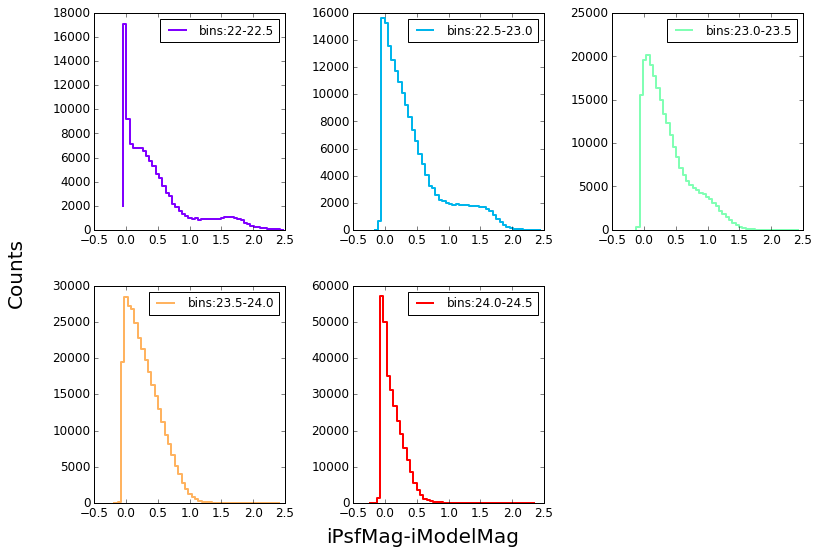

In [321]:
bin_start = 22
bin_end = 22.5
from matplotlib.pyplot import cm 
n = 5
color=iter(cm.rainbow(np.linspace(0,1,n)))

ylim = [-0.5,2.5]
mask_y = ((iPsf-iModel) < ylim[1]) & ((iPsf-iModel) > ylim[0])


nbins=50
fig,ax = plt.subplots(2,3,  figsize=(12,8),sharex = False)
axs = np.ravel(ax)
for i in range(5):
    
    print('Range iModelMag %.1f to %.1f' %(bin_start, bin_end))
    
    mask_bin = (iModel > (bin_start)) & (iModel < (bin_end))
    mask = mask_bin * mask_y 
    print np.sum(mask)
    
    hist, bin_edges = np.histogram(iPsf[mask]-iModel[mask], bins=nbins, density=False)
    bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
    axs[i].plot(bin_cen, hist, color = 'red', ls='steps', c =next(color), lw=2, label='bins:'+str(bin_start)+'-'+str(bin_end))
    axs[i].legend(fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    bin_start += 0.5 
    bin_end += 0.5 
axs[i+1].axis('off')
fig.text(0.5, 0.04, 'iPsfMag-iModelMag', ha='center', va='center',fontsize=20)
fig.text(0.03, 0.5, 'Counts', ha='center', va='center', rotation='vertical',fontsize=20)

fig.tight_layout()
fig.subplots_adjust(wspace=0.36, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.95)
plt.savefig('Extendedness_coadd_histograms.png')

In [215]:
# Grab only extendedness from deep_src  to merge with the photometric information below...

deep_src_ext = deep_src[['deepSourceId', 'extendedness']]


In [230]:
#Save the original file without all the unneccesary rows, to compare how much do new columns weight 
#fp = pd.read_table(DirIn+'rawDataFP/'+name, nrows=200000,usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'])
#fp.to_csv('orig_'+name) 

In [6]:
fp_data[fp_data['flag']==1].head()

,objectId,mjd,psfFlux,psfFluxErr,flag,faintMean,faintMedian,faintTwoSigma
70,217720894888346425,51465.169058,6.175596e-30,4.464454e-30,1,6.921945e-30,6.642480e-30,1.370556e-29
71,217720894888346425,51465.169473,8.374562e-30,4.264869e-30,1,8.628334e-30,8.507077e-30,1.544141e-29
72,217720894888346425,51819.249392,5.192472e-30,3.894484e-30,1,5.895361e-30,5.638685e-30,1.177720e-29
73,217720894888346425,52172.265070,4.805238e-30,3.868769e-30,1,5.604499e-30,5.326148e-30,1.137889e-29
74,217720894888346425,52552.206271,3.671874e-30,3.550230e-30,1,4.648490e-30,4.345582e-30,9.787726e-30


## Photometric Data 

In [176]:
# Photometry in each small square patch was saved to  
#  /rawDataFP/

# When it was  sorted according to objID, the result was saved to 
#  /rawDataFPSplit/ 
#  g176_181  means   g filter,  from patch 176 to 181.  

# Use this for LIGHTCURVES   because they are here 
# 


fp_data = pd.read_csv(DirIn+'rawDataFPSplit/g176_181.csv', nrows=200000)
fp_data.head()

,id,objectId,exposure_id,mjd,psfFlux,psfFluxErr
0,69800609997395793,217720894888346422,1040110141,51465.169058,1.150479e-27,2.162019e-29
1,117783446146782904,217720894888346422,1755110117,51819.248977,1.267535e-27,2.221305e-29
2,173349585874327603,217720894888346422,2583110122,52172.264656,1.295309e-27,2.314595e-29
3,225493171860150836,217720894888346422,3360110102,52552.205857,1.285701e-27,2.344647e-29
4,227372217300687184,217720894888346422,3388110061,52558.214566,1.302808e-27,2.570647e-29


## Group by object Id,  select first object, and plot its lightcurve... 

In [7]:
grouped = fp_data.groupby('objectId')

# Find what are the objectId's in the grouped object of forced photometries 
obj_in_fp = []
for name, group in grouped:
    obj_in_fp.append(name)


    
    

In [76]:
grouped.get_group(obj_in_fp[1]).loc[:,'mjd'].values

array([ 51465.169058  ,  51465.1694727 ,  51819.2493917 ,  52172.2650704 ,
        52552.2062713 ,  52558.2145657 ,  52576.1268727 ,  52577.1023406 ,
        52930.1153584 ,  52931.1164897 ,  52935.1134372 ,  53313.1063648 ,
        53622.21556204,  53622.21597674,  53625.21171771,  53634.16505088,
        53634.16546547,  53636.17093844,  53655.1428206 ,  53664.16760521,
        53666.1315154 ,  53669.12711014,  53676.20058026,  53679.17240933,
        53679.17282392,  53681.16429554,  53685.12328287,  53687.16145145,
        53694.13687467,  53697.12093364,  53697.12134834,  53700.12024883,
        53705.10670584,  53975.19191498,  53996.19829841,  53998.16719937,
        54010.15255635,  54012.14528929,  54020.15136493,  54022.20076563,
        54028.14171016,  54030.14480895,  54032.13415206,  54034.20452031,
        54037.12609365,  54040.14085584,  54050.12544524,  54053.13151005,
        54056.13311696,  54057.10178216,  54059.12737478,  54061.13835292,
        54062.13223751,  

In [329]:
#grouped.get_group(obj_in_fp[0])

In [215]:

# retrieve mjd and psfFlux  for the first object in the list 
print('Obj ID = %d'%obj_in_fp[0])
mjd = grouped.get_group(obj_in_fp[0])['mjd'].values
g_flux  =grouped.get_group(obj_in_fp[0])['psfFlux'].values  
g_flux_err =grouped.get_group(obj_in_fp[0])['psfFluxErr'].values   

Obj ID = 217720894888346422


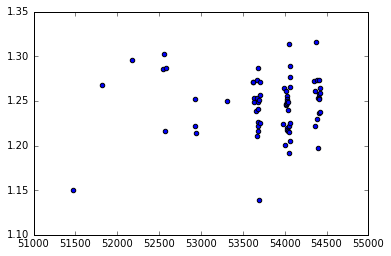

In [427]:
# plot the example of a lightcurve , scaled by a factor ... 

%matplotlib inline 
plt.scatter(mjd, g_flux*1e27)

In [59]:
# Extract year information for that object to make year-averages... 

t = Time(mjd, format='mjd')
int_year = [ int(times) for times in t.jyear]
mnths = [date.month for date in t.datetime]

In [60]:
#np.unique(mnths)
# Show which months were the observations made in...
#plt.hist(mnths, bins=np.arange(12))

Z. : "One correction: you take the median, not rms, for a seasons (a few months per year).
Then you look at the rms of these medians over a few years.  It’d be good to use robust 
inter-quartile range based rms. It might be better to use a clipped mean instead of median
for the first step, but we don’t know it for a fact at this time. In other words, it’d be good
to try both options."

In [61]:
from astropy.stats import sigma_clip
# https://astropy.readthedocs.org/en/v0.2b2/_generated/astropy.stats.funcs.sigma_clip.html 
#sigma_clip(year_flux, sigma=2, iters=1)

In [62]:
# below I do median for a year, because I can't figure out how to take the median over a few months : 
# which months to choose, etc ?  
from astropy.stats import sigma_clip

# test that for one object  

years = np.unique(int_year)
Nobs  = np.zeros_like(years).astype(float)
season_median = np.zeros_like(years).astype(float)
season_clippedMean = np.zeros_like(years).astype(float)

for i in range(len(years)):
    year = years[i]
    condition = (int_year == year)     # select obs from a given year 
    N = float(len(g_flux[condition]))  # how many times an object was observed that year ?           
    Nobs[i] = N
    year_flux = g_flux[condition]
    season_clippedMean[i]  = np.mean(sigma_clip(year_flux, sigma=2))
    season_median[i] = np.median(year_flux) 
    
# based on those seasonal averages I calculate one number  
    
rmsClipped = np.sqrt(np.mean(np.square(season_clippedMean)))
rmsClippedIQR =  0.7414 *(np.percentile(season_clippedMean,75) - np.percentile(season_clippedMean,25))

rmsMedian =  np.sqrt(np.mean(np.square(season_median)))
rmsMedianIQR =  0.7414 *(np.percentile(season_median,75) - np.percentile(season_median,25))


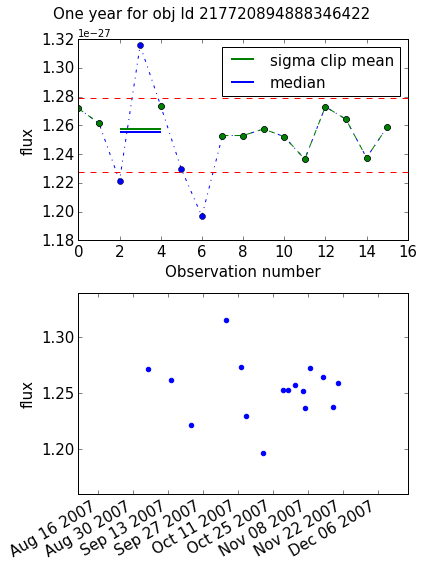

In [85]:
# Show that 2-sigma clipping works 

nSigma = 2
fig,ax = plt.subplots(2,1, figsize=(6,8))
ax[0].plot(year_flux, marker='o', linestyle='-.', color='blue')
ax[0].plot(sigma_clip(year_flux,sigma=nSigma),marker='o', linestyle='--', color='green')
ax[0].axhline(y= np.mean(year_flux)+ np.std(year_flux), linestyle='--', color='red')
ax[0].axhline(y= np.mean(year_flux)- np.std(year_flux), linestyle='--', color='red')
ax[0].hlines(xmin=2,xmax=4, y = np.mean(sigma_clip(year_flux, sigma=2)), label = 'sigma clip mean', color='green', lw=2)
ax[0].hlines(xmin=2,xmax=4, y = np.median(year_flux), label = 'median', color='blue', lw=2)
ax[0].legend( fontsize=15)
ax[0].set_xlabel('Observation number',  fontsize=15)
ax[0].set_ylabel('flux', fontsize=15)
fig.suptitle('One year for obj Id '+str(obj_in_fp[0]), fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
# Show what the points above correspond to in an actual timeseries  

ax[1].scatter( t.datetime[condition], year_flux*1e27,marker='o',  color='blue')
ax[1].set_ylabel('flux', fontsize=15)

#ax[1].autofmt_xdate()
plt.setp(plt.xticks()[1], rotation=30, ha='right')
ax[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
fig.subplots_adjust( hspace=0.26, top=0.923)
plt.savefig('Lightcurve_year_obj_'+str(obj_in_fp[0])+'.png')
plt.show()

In [114]:
year = [Time(2000+i, 1,1,0,0,0) for i in range(8)]
year_t = Time(year, format='datetime')
year_t

ValueError: in_subfmt attribute must be a string

In [128]:
year = [2000+i for i in range(8)]
year_t = Time(year, format='byear')
year_t[6].iso

'2005-12-31 11:40:41.931'

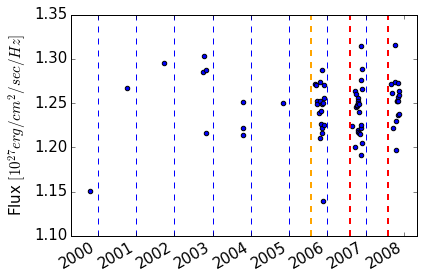

In [214]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(t.datetime, g_flux*1e27)
for year in year_t:
    ax.axvline(x = year.datetime, linestyle='--')

ax.set_ylabel('Flux '+r'$ [10^{27} erg/cm^{2}/sec/Hz]$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)   
fig.autofmt_xdate()
t_cut = Time('2005-08-01 00:00:00.000', format='iso')
ax.axvline(t_cut.datetime, linestyle='--', color='orange', lw=2)
cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')
for i in range(1,len(cutDates)-1): 
    ax.axvline(cutDates[i].datetime, linestyle='--', color='red', lw=2)
plt.tight_layout()
plt.savefig('Lightcurve_full_obj_'+str(obj_in_fp[0])+'.png')

In [182]:
t_cut = Time('2005-08-01 00:00:00.000', format='iso')
maskTimePre = t.datetime < t_cut.datetime

In [183]:
g_flux[mask_time]

array([  1.15047917e-27,   1.26753514e-27,   1.29530855e-27,
         1.28570132e-27,   1.30280824e-27,   1.21608256e-27,
         1.28713011e-27,   1.25176466e-27,   1.22238120e-27,
         1.21377531e-27,   1.25031302e-27])

In [184]:
t[maskTimePre].datetime

array([datetime.datetime(1999, 10, 14, 4, 3, 26, 611201),
       datetime.datetime(2000, 10, 2, 5, 58, 31, 612800),
       datetime.datetime(2001, 9, 20, 6, 21, 6, 252480),
       datetime.datetime(2002, 10, 5, 4, 56, 26, 10240),
       datetime.datetime(2002, 10, 11, 5, 8, 58, 476479),
       datetime.datetime(2002, 10, 29, 3, 2, 41, 801280),
       datetime.datetime(2002, 10, 30, 2, 26, 46, 380479),
       datetime.datetime(2003, 10, 18, 2, 46, 6, 965761),
       datetime.datetime(2003, 10, 19, 2, 47, 8, 871361),
       datetime.datetime(2003, 10, 23, 2, 42, 45, 144000),
       datetime.datetime(2004, 11, 4, 2, 33, 9, 918721)], dtype=object)

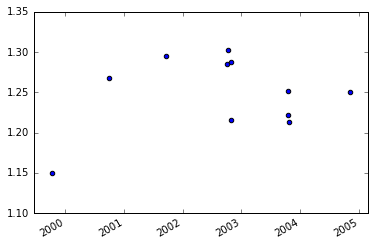

In [185]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(t[maskTimePre].datetime, g_flux[maskTimePre]*1e27)
fig.autofmt_xdate()

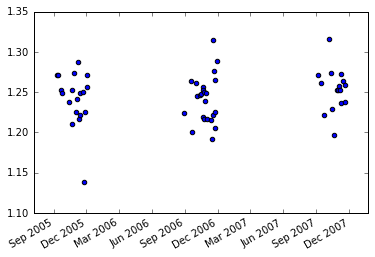

In [186]:
maskTimePost = t.datetime > t_cut.datetime
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(t[maskTimePost].datetime, g_flux[maskTimePost]*1e27)
fig.autofmt_xdate()

In [201]:
cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')

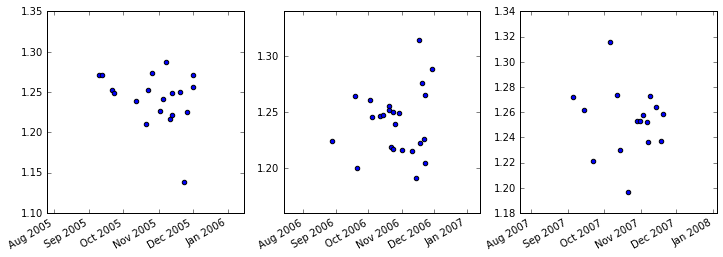

In [200]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
for i in range(len(cutDates)-1):
    maskTimeAnn = (t > cutDates[i])*(t<cutDates[i+1])
    ax[i].scatter(t[maskTimeAnn].datetime, g_flux[maskTimeAnn]*1e27 )
# fig.autofmt_xdate()

In [232]:
# This is a test...

# retrieve mjd and psfFlux  for the first object in the list 
print('Obj ID = %d'%obj_in_fp[0])
mjd = grouped.get_group(obj_in_fp[0])['mjd'].values
t = Time(mjd, format='mjd')
g_flux  =grouped.get_group(obj_in_fp[0])['psfFlux'].values  
g_flux_err =grouped.get_group(obj_in_fp[0])['psfFluxErr'].values  

obj_dic = {'objectId':[], 'avgMJD':[], 'MJDrange':[], 'meanFlux':[], 'medianFlux':[], 'rmsErr':[], 'sigG':[]}

obj = obj_in_fp[0]

# calculate the stats before t_cut


t_cut = Time('2005-08-01 00:00:00.000', format='iso')
maskTimePre = t.datetime < t_cut.datetime
mask = maskTimePre

avgMJD = np.average(t[mask].mjd)
MJDrange = max(t[mask].mjd) - min(t[maskTimePre].mjd)
weights=1.0 / ( g_flux_err[mask] ** 2.0) 
meanFlux = np.average( g_flux[mask],weights= weights)
    # same as  np.sum(weights * g_flux[maskTimePre]) / np.sum(weights)  
medianFlux = np.median(g_flux[mask])    
rmsErr = np.power(np.sum(weights), -0.5)
sigG = 0.7414 *(np.percentile( g_flux[mask],75) - np.percentile( g_flux[mask],25))
obj_dic['objectId'].append(obj)
obj_dic['avgMJD'].append(avgMJD)
obj_dic['MJDrange'].append(MJDrange)
obj_dic['meanFlux'].append(meanFlux)
obj_dic['medianFlux'].append(medianFlux)
obj_dic['rmsErr'].append(rmsErr)
obj_dic['sigG'].append(sigG)
        
# calculate the stats after the cut 
cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')
for i in range(len(cutDates)-1):
    
    maskTimeAnn = (t > cutDates[i])*(t<cutDates[i+1])
    mask = maskTimeAnn
    avgMJD = np.average(t[mask].mjd)
    MJDrange = max(t[mask].mjd) - min(t[maskTimePre].mjd)
    weights=1.0 / ( g_flux_err[mask] ** 2.0) 
    meanFlux = np.average( g_flux[mask],weights= weights)
        # same as  np.sum(weights * g_flux[maskTimePre]) / np.sum(weights)  
    medianFlux = np.median(g_flux[mask])    
    rmsErr = np.power(np.sum(weights), -0.5)
    sigG = 0.7414 *(np.percentile( g_flux[mask],75) - np.percentile( g_flux[mask],25))
    obj_dic['objectId'].append(obj)
    obj_dic['avgMJD'].append(avgMJD)
    obj_dic['MJDrange'].append(MJDrange)
    obj_dic['meanFlux'].append(meanFlux)
    obj_dic['medianFlux'].append(medianFlux)
    obj_dic['rmsErr'].append(rmsErr)
    obj_dic['sigG'].append(sigG)

Obj ID = 217720894888346422


In [233]:
obj_dic

{'MJDrange': [1847.9373068000059,
  2239.9376478399936,
  2602.952810029994,
  2958.9489331699951],
 'avgMJD': [52529.980248363638,
  53672.100163867057,
  54034.396379050013,
  54395.535422800625],
 'meanFlux': [1.2469320888019784e-27,
  1.246513646171513e-27,
  1.2379865728304246e-27,
  1.2564447791166354e-27],
 'medianFlux': [1.2517646585052606e-27,
  1.2489119006312099e-27,
  1.2460187975304416e-27,
  1.2551758504845832e-27],
 'objectId': [217720894888346422,
  217720894888346422,
  217720894888346422,
  217720894888346422],
 'rmsErr': [6.7844239847559963e-30,
  5.4503413340187911e-30,
  4.8529574309354299e-30,
  5.4700190189791675e-30],
 'sigG': [4.9810097069962938e-29,
  2.8135966785573043e-29,
  2.8587821985735315e-29,
  2.140121519873466e-29]}

In [288]:
np.array(obj_dic['MJDrange'])[mask]

array([ 1847.9373068 ,  2239.93764784,  2602.95281003,  2958.94893317])

In [317]:
factor   = np.power(10, -np.floor(np.log10(100*np.mean(g_flux))))

In [318]:
factor

1e+27

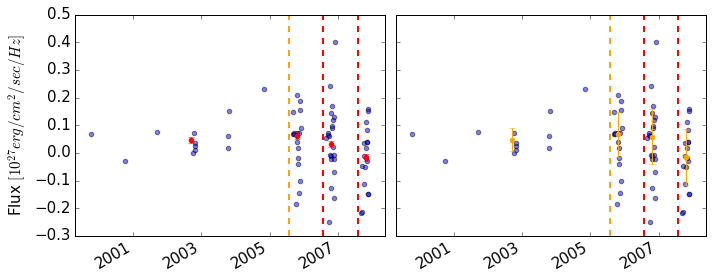

Obj ID = 217720894888346422


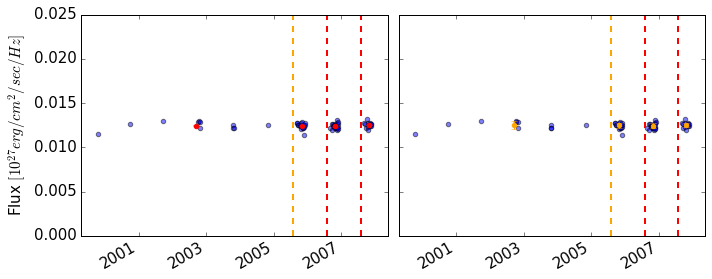

In [352]:
# This version creates a dict of dicts ,  which doesn't work very well, because I have 
# no idea how to make a dataframe from something like that 
# For this reason, I prefer to have objectId multiple times, but at least it's easier to visualise 
obj_dic = {}

def calculate_obj_stats(obj, obj_dic):
    obj_dic[str(obj)] = {'avgMJD':[], 'MJDrange':[], 'meanFlux':[], 'medianFlux':[], 'rmsErr':[], 'sigG':[]}
    print('Obj ID = %d'%obj)
    mjd = grouped.get_group(obj)['mjd'].values
    t = Time(mjd, format='mjd')
    g_flux  =grouped.get_group(obj)['psfFlux'].values  
    g_flux_err =grouped.get_group(obj)['psfFluxErr'].values  

    # calculate the stats before t_cut

    t_cut = Time('2005-08-01 00:00:00.000', format='iso')
    maskTimePre = t.datetime < t_cut.datetime
    mask = maskTimePre

    avgMJD = np.average(t[mask].mjd)
    MJDrange = max(t[mask].mjd) - min(t[maskTimePre].mjd)
    weights=1.0 / ( g_flux_err[mask] ** 2.0) 
    meanFlux = np.average( g_flux[mask],weights= weights)
        # same as  np.sum(weights * g_flux[maskTimePre]) / np.sum(weights)  
    medianFlux = np.median(g_flux[mask])    
    rmsErr = np.power(np.sum(weights), -0.5)
    sigG = 0.7414 *(np.percentile( g_flux[mask],75) - np.percentile( g_flux[mask],25))

    obj_dic[str(obj)]['avgMJD'].append(avgMJD)
    obj_dic[str(obj)]['MJDrange'].append(MJDrange)
    obj_dic[str(obj)]['meanFlux'].append(meanFlux)
    obj_dic[str(obj)]['medianFlux'].append(medianFlux)
    obj_dic[str(obj)]['rmsErr'].append(rmsErr)
    obj_dic[str(obj)]['sigG'].append(sigG)

    # calculate the stats after the cut 
    cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')
    for i in range(len(cutDates)-1):

        maskTimeAnn = (t > cutDates[i])*(t<cutDates[i+1])
        mask = maskTimeAnn
        avgMJD = np.average(t[mask].mjd)
        MJDrange = max(t[mask].mjd) - min(t[maskTimePre].mjd)
        weights=1.0 / ( g_flux_err[mask] ** 2.0) 
        meanFlux = np.average( g_flux[mask],weights= weights)
            # same as  np.sum(weights * g_flux[maskTimePre]) / np.sum(weights)  
        medianFlux = np.median(g_flux[mask])    
        rmsErr = np.power(np.sum(weights), -0.5)
        sigG = 0.7414 *(np.percentile( g_flux[mask],75) - np.percentile( g_flux[mask],25))
      
        obj_dic[str(obj)]['avgMJD'].append(avgMJD)
        obj_dic[str(obj)]['MJDrange'].append(MJDrange)
        obj_dic[str(obj)]['meanFlux'].append(meanFlux)
        obj_dic[str(obj)]['medianFlux'].append(medianFlux)
        obj_dic[str(obj)]['rmsErr'].append(rmsErr)
        obj_dic[str(obj)]['sigG'].append(sigG)

N=0  # choose the zeroth object 

calculate_obj_stats(obj_in_fp[N], obj_dic)
obj = obj_in_fp[N]
mjd = grouped.get_group(obj)['mjd'].values
t = Time(mjd, format='mjd')
g_flux  =grouped.get_group(obj)['psfFlux'].values  
factor   = np.power(10, -np.floor(np.log10(100*np.mean(g_flux))))
fig,ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(t.datetime, g_flux*factor, alpha = 0.5)
x = Time(obj_dic[str(obj)]['avgMJD'], format='mjd').datetime
y = np.array(obj_dic[str(obj)]['meanFlux'])*factor
yErr = np.array(obj_dic[str(obj)]['rmsErr'])*factor
ax[0].scatter(x,y, color='red')
ax[0].errorbar(x,y,yErr, linestyle='None', color='red' )

ax[1].scatter(t.datetime, g_flux*factor,alpha = 0.5)
y = np.array(obj_dic[str(obj)]['medianFlux'])*factor
yErr = np.array(obj_dic[str(obj)]['sigG'])*factor
ax[1].scatter(x,y, color='orange')
ax[1].errorbar(x,y,yErr, linestyle='None', color='orange' )

ax[0].set_ylabel('Flux '+r'$ [10^{27} erg/cm^{2}/sec/Hz]$', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)   
ticks = ax[0].get_xticks()
ax[0].set_xticks(ticks[1::2])
ax[1].tick_params(axis='both', which='major', labelsize=15)   
ticks = ax[1].get_xticks()
ax[1].set_xticks(ticks[1::2])
ax[1].yaxis.set_ticklabels([])



t_cut = Time('2005-08-01 00:00:00.000', format='iso')
cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')

for axis in ax : 
    axis.axvline(t_cut.datetime, linestyle='--', color='orange', lw=2)
    for i in range(1,len(cutDates)-1): 
        axis.axvline(cutDates[i].datetime, linestyle='--', color='red', lw=2)

    
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('Lightcurve_full_seasonal_obj_'+str(obj_in_fp[0])+'.png')

## If want to show how the seasonal averaging works, make a figure... 

28


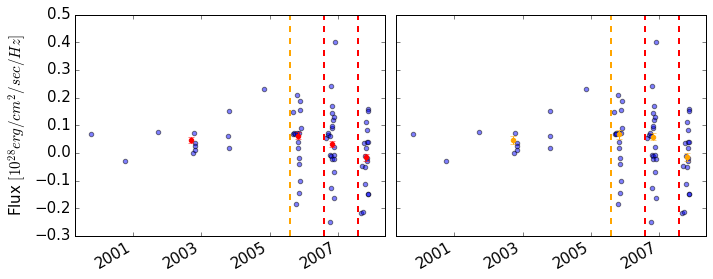

In [166]:
fp_data = pd.read_csv(DirIn+'rawDataFPSplit/g176_181.csv', nrows=200000)
#fp_data.head()

grouped = fp_data.groupby('objectId')

#Plot the outcome of averaging for the zeroth object 
N=2  # choose the zeroth object 
obj = obj_in_fp[N]
# Make sure that it has actually been calculated!
#seasonAvg = seasonal_data_averages(obj, seasonAvg)


mjd = grouped.get_group(obj)['mjd'].values
t = Time(mjd, format='mjd')
g_flux  =grouped.get_group(obj)['psfFlux'].values  
factor   = np.power(10, -np.floor(np.log10(100*np.mean(g_flux))))
fig,ax = plt.subplots(1,2, figsize=(10,4))


mask = np.array(seasonAvg['objectId']) == obj
ax[0].scatter(t.datetime, g_flux*factor, alpha = 0.5)
x = Time(np.array(seasonAvg['avgMJD'])[mask], format='mjd').datetime
y = np.array(seasonAvg['meanFlux'])[mask]*factor
yErr = np.array(seasonAvg['meanErr'])[mask]*factor
ax[0].scatter(x,y, color='red')
ax[0].errorbar(x,y,yErr, linestyle='None', color='red' )

ax[1].scatter(t.datetime, g_flux*factor,alpha = 0.5)
y = np.array(seasonAvg['medianFlux'])[mask]*factor
yErr = np.array(seasonAvg['medianErr'])[mask]*factor
ax[1].scatter(x,y, color='orange')
ax[1].errorbar(x,y,yErr, linestyle='None', color='orange' )

ax[0].set_ylabel('Flux '+r'$ [10^{'+str(np.log10(factor))[:2]+'} erg/cm^{2}/sec/Hz]$', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)   
ticks = ax[0].get_xticks()
ax[0].set_xticks(ticks[1::2])
ax[1].tick_params(axis='both', which='major', labelsize=15)   
ticks = ax[1].get_xticks()
ax[1].set_xticks(ticks[1::2])
ax[1].yaxis.set_ticklabels([])



t_cut = Time('2005-08-01 00:00:00.000', format='iso')
cutDates= Time([str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,max(t).datetime.year+2 )], format='iso')

for axis in ax : 
    axis.axvline(t_cut.datetime, linestyle='--', color='orange', lw=2)
    for i in range(1,len(cutDates)-1): 
        axis.axvline(cutDates[i].datetime, linestyle='--', color='red', lw=2)

    
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('Lightcurve_full_seasonal_obj_'+str(obj)+'.png')
print str(np.log10(factor))[:2]

# Calculate seasonal chi2  grouping by objectId...

In [266]:
#grouped.groups.keys()

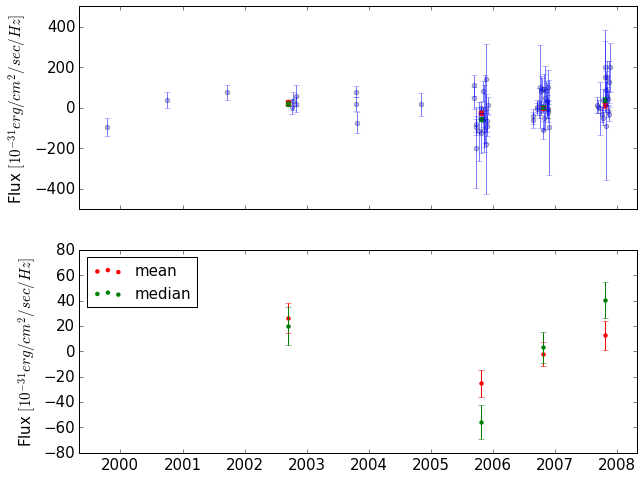

In [273]:
fp_data = pd.read_csv(DirIn+'rawDataFPSplit/g176_181.csv', nrows=200000)

grouped = fp_data.groupby('objectId')

obj = objects[6]
# Make sure that it has actually been calculated!
#seasonAvg = seasonal_data_averages(obj, seasonAvg)

mjd = grouped.get_group(obj)['mjd'].values
t = Time(mjd, format='mjd')
flux  =grouped.get_group(obj)['psfFlux'].values 
fluxErr = grouped.get_group(obj)['psfFluxErr'].values 
f   = np.power(10, -np.floor(np.log10(np.mean(flux))))

fig,ax = plt.subplots(2,1, figsize=(10,8), sharex=True)


mask = np.array(seasonAvg['objectId']) == obj
ax[0].scatter(t.datetime, f*flux, alpha = 0.3)
ax[0].errorbar(t.datetime,f*flux, f*fluxErr, linestyle='None', alpha=0.5)

x = Time(np.array(seasonAvg['avgMJD'])[mask], format='mjd').datetime
y = np.array(seasonAvg['meanFlux'])[mask]
yErr = np.array(seasonAvg['meanErr'])[mask]
ax[0].scatter(x,f*y, color='red')
ax[0].errorbar(x,f*y,f*yErr, linestyle='None', color='red' )

y= np.array(seasonAvg['medianFlux'])[mask]
yerr = np.array(seasonAvg['medianErr'])[mask]
ax[0].scatter(x,f*y, color='g')
ax[0].errorbar(x,f*y,f*yErr, linestyle='None', color='g' )
ax[0].set_ylabel('Flux '+r'$ [10^{-'+str(np.log10(f))[:2]+'} erg/cm^{2}/sec/Hz]$', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15) 

y= np.array(seasonAvg['meanFlux'])[mask]
yerr = np.array(seasonAvg['meanErr'])[mask]
f   = np.power(10, -np.floor(np.log10(np.mean(y))))
ax[1].scatter(x,y*f, c='r', lw=0, label='mean')
ax[1].errorbar(x, y*f,yerr*f, linestyle='None', c='r')

y= np.array(seasonAvg['medianFlux'])[mask]
yerr = np.array(seasonAvg['medianErr'])[mask]
ax[1].scatter(x,y*f, lw=0, c='g', label='median')
ax[1].errorbar(x, y*f,yerr*f, linestyle='None', c='g')
ax[1].set_ylabel('Flux '+r'$ [10^{-'+str(np.log10(f))[:2]+'} erg/cm^{2}/sec/Hz]$', fontsize=15)
ax[1].legend(loc='upper left', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15) 
plt.savefig('lightcurve_obj_'+str(obj)+'.png')

1.33151458769e-29
5.31603511372
1.99636282859


<Container object of 3 artists>

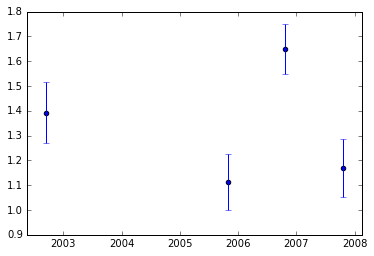

In [255]:
# Calculate by hand the chi2DOF_mean ... 
y= np.array(seasonAvg['meanFlux'])[mask]
yerr = np.array(seasonAvg['meanErr'])[mask]
N = len(y)
if N < 2:
    print(np.nan)
else:
    print(np.mean(y))
    chi2 = np.sum(((y-np.mean(y))**2)/(yerr**2))
    Z = (y - np.median(y)) / yerr
    chi2R = 0.7414*(np.percentile(Z,75) - np.percentile(Z,25))
    print(chi2/(N-1))
    print(chi2R)
plt.scatter(x,y*1e29)
plt.errorbar(x, y*1e29,yerr*1e29, linestyle='None')


In [142]:
# Calculate by hand the chi2DOF_median ... 
y= np.array(seasonAvg['medianFlux'])[mask]
yerr = np.array(seasonAvg['medianErr'])[mask]
N = len(y)
if N < 2:
    print(np.nan)
else:
    chi2 = np.sum(((y-np.mean(y))/yerr)**2)
    print(chi2/(N-1))


8.13115030243


## DEAD END  : FluxMag0s 

FluxMag0 is defined as flux (in counts) that a zero magnitude source would have on that image. This can be used to find the zero point magnitude which is defined as the magnitude a 1 count source would have (please look up the precise conversion).  These fluxmag0s were calibrated using the Ivezic+07 catalog. 

The files in NCSA are RA < 10deg are split up by run ( the fraction of a strip observed at one time (limited by observing conditions)).
The files in IN2P3 RA > 5deg are split up by band

In [9]:
#Single Epoch images Science_Ccd_Exposure.csv column names
#Implied first column is scienceCcdExposureId
SCIENCE_CCD_EXPOSURE_COLS = [
    'run', 'camcol', 'filterId', 'field', 'filterName', 'ra', 'decl',
    'equinox', 'raDeSys', 'ctype1', 'ctype2', 'crpix1', 'crpix2',
    'crval1', 'crval2', 'cd1_1', 'cd1_2', 'cd2_1', 'cd2_2',
    'corner1Ra', 'corner1Decl', 'corner2Ra', 'corner2Decl',
    'corner3Ra', 'corner3Decl', 'corner4Ra', 'corner4Decl',
    'taiMjd', 'obsStart', 'expMidpt', 'expTime',
    'nCombine', 'binX', 'binY', 'fluxMag0', 'fluxMag0Sigma', 'fwhm', 'path']
scienceCcdExpFilename = DirIn+ 'IN2P3/ScienceCcdExposure/g_Science_Ccd_Exposure.csv'
sce = pd.read_csv(scienceCcdExpFilename,
                     header=None, index_col=0, nrows=2000)
sce.columns = SCIENCE_CCD_EXPOSURE_COLS
sce.index.name = 'exposure_id'

In [41]:
#sce.head()

In [19]:
# The first Exposure ID 
sce.index[0]

5823160438

In [24]:
# The FluxMag0  for the First Exposure ID 
sce.loc[sce.index[0]]['fluxMag0']

251190775783.207

In [25]:
sce['mag_0_pt'] = 2.5* np.log10(sce['fluxMag0'])

In [27]:
# Can plot a histogram of zero point magnitudes for all obs in g band if I need to 
plt.hist(sce['mag_0_pt'].values)
plt.show()

(array([  52.,  271.,   90.,  636.,  571.,   67.,    5.,  103.,  203.,    2.]),
 array([ 28.37385266,  28.40900653,  28.4441604 ,  28.47931427,
         28.51446813,  28.549622  ,  28.58477587,  28.61992974,
         28.65508361,  28.69023748,  28.72539134]),
 <a list of 10 Patch objects>)

## Color Data  : median of photometry... 

### Coadd photometry median : DON'T USE 

In [53]:
# This file includes median of coadd photometry,  and E(B-V)  
# It has a coadd photometry  , meaning that it should not be used for colors - 
# it takes the median of brightness measurements in a given filter only when 
# the object was above detection threshold (MEDIAN OVER ALL DETECTIONS)
# which means that it is biased towards higher brightness, if sometimes the object went below 
# detectability .
#
# Use ONLY FOR E(B-V)  correction  !!  

# The problem is that for a random object, the p

med_coadd_phot = pd.read_csv(DirIn+'medianPhotometry.csv', nrows=2000, usecols=['objectId','ebv'])

In [54]:
# Can't find my object for which I plotted the lightcurve above, because it's not within the first n lines I select...
med_coadd_phot.head()

,objectId,ebv
0,3201778262737340,0.022957
1,3201778262737342,0.023353
2,3201778262737343,0.023417
3,3201778262737345,0.024297
4,3201778262737346,0.024679


In [63]:
# From this file,  grab the objectId and ebv,  and join  on objectId (which is unique to both 
# medianPhotometry.csv and ugrizMetrics.csv)

med_coadd_ebv = med_coadd_phot[['objectId', 'ebv']]
med_coadd_ebv.head()

,objectId,ebv
0,3201778262737340,0.022957
1,3201778262737342,0.023353
2,3201778262737343,0.023417
3,3201778262737345,0.024297
4,3201778262737346,0.024679


### Catalog photometry median : USE THAT !  

In [6]:
ugrizMetrics = pd.read_csv(DirIn+'lightcurveMetrics/metricsFiles/i_metrics.csv', nrows=200000)

In [7]:
ugrizMetrics.head()

,objectId,N,WeightedMean,WeightedStdCorr,chi2,e50,e_mean,mean,median,sigmaG,annAvg_chi2_clip_wm,annAvg_chi2_median,annAvg_chi2_wm,annAvg_e50_clip_wm,annAvg_rms_clip_wm,sigmaClipped_std,sigmaClipped_chi2,sigmaClipped_wm,sigmaClipped_N,sigmaClipped_wStdCorr,sigmaClipped_mean,BB_ltau,BB_chi2_qso/nu,BB_chi2_qso/nu_NULL,BB_class,BB_lvar,BB_signif_not_qso,BB_signif_vary,BB_nu,BB_signif_qso,BB_chi2/nu
0,3412884495270282,67,1.962891e-29,1.501662e-30,1.634843,1.019602e-29,1.150987e-29,2.009854e-29,1.962789e-29,1.068462e-29,6.489706,12.588398,5.078756,3.083797e-30,9.059378e-30,1.231963e-29,1.134177,1.914793e-29,64,1.259665e-30,1.906101e-29,2.501620,1.330246,2.118807,ambiguous,-3.515493,1.498745,3.567986,60,2.099785,1.735427
1,3412884495270287,69,1.414812e-29,1.289753e-30,1.281462,1.006935e-29,1.154684e-29,1.289703e-29,1.137923e-29,1.151897e-29,3.029758,3.483251,3.029758,3.107391e-30,8.916189e-30,1.241649e-29,1.281462,1.414812e-29,69,1.289753e-30,1.289703e-29,2.461367,0.585649,1.884533,ambiguous,-3.461823,0.026280,0.029178,58,4.501388,0.665424
2,3412884495270291,69,2.529276e-29,1.323982e-30,1.365649,1.045984e-29,1.161630e-29,2.730206e-29,2.595336e-29,1.338154e-29,1.464328,4.241737,1.311904,3.217803e-30,5.201236e-30,1.301804e-29,1.365649,2.529276e-29,69,1.323982e-30,2.730206e-29,2.543313,0.940838,1.881864,ambiguous,-3.571084,0.527019,0.871829,66,3.015995,1.042175
3,3412884495270293,63,1.210740e-29,1.242681e-30,1.080959,1.017732e-29,1.139159e-29,1.116413e-29,1.074927e-29,1.195944e-29,4.675092,4.854359,4.675092,2.811502e-30,7.390886e-30,1.174949e-29,1.080959,1.210740e-29,63,1.242681e-30,1.116413e-29,2.422467,0.399493,2.453840,ambiguous,-3.409956,0.000677,0.000079,52,6.303398,0.416181
4,3412884495270298,70,5.779936e-29,1.292293e-30,1.237279,1.031339e-29,1.146549e-29,5.883732e-29,5.900363e-29,1.134468e-29,5.115755,13.891772,4.164408,3.517507e-30,6.944158e-30,1.251325e-29,1.156362,5.769151e-29,69,1.256018e-30,5.776260e-29,2.674071,1.049350,2.354052,ambiguous,-3.745428,0.805671,1.594321,69,3.512526,1.211879


In [503]:
# This file includes the median of catalog photometry,
# which is the unbiased color : 
# it takes the median of brightness measurement
# over all epochs - such median may even be below detectability if 
# the object went undetected for many epochs - but it 
# better reflects the actual brightness of the source 
#
# Use for COLORS   !! 

med_cat_phot = pd.read_csv(DirIn+'lightcurveMetrics/metricsFiles/ugrizMetrics.csv', nrows=200000)



In [85]:
med_cat_phot.head()

,objectId,N_u,median_u,sigmaG_u,e_mean_u,e50_u,annAvg_chi2_clip_wm_u,median_mag_u,e50_mag_u,iqrSig_mag_u,N_g,median_g,sigmaG_g,e_mean_g,e50_g,annAvg_chi2_clip_wm_g,median_mag_g,e50_mag_g,iqrSig_mag_g,N_r,median_r,sigmaG_r,e_mean_r,e50_r,annAvg_chi2_clip_wm_r,median_mag_r,e50_mag_r,iqrSig_mag_r,N_i,median_i,sigmaG_i,e_mean_i,e50_i,annAvg_chi2_clip_wm_i,median_mag_i,e50_mag_i,iqrSig_mag_i,N_z,median_z,sigmaG_z,e_mean_z,e50_z,annAvg_chi2_clip_wm_z,median_mag_z,e50_mag_z,iqrSig_mag_z
0,3412884495270282,67,5.572298e-30,1.336731e-29,1.589279e-29,1.025420e-29,3.198440,24.534914,1.997984,2.604559,66,5.550917e-30,8.491647e-30,6.925084e-30,4.581137e-30,13.457120,24.539088,0.896051,1.660931,67,1.026962e-29,7.926279e-30,1.026927e-29,6.740401e-30,12.880008,23.871114,0.712616,0.837991,67,1.962789e-29,1.068462e-29,1.150987e-29,1.019602e-29,6.489706,23.167816,0.564003,0.591030,67,2.826974e-29,3.999308e-29,4.263174e-29,4.078581e-29,1.186833,22.771696,1.566432,1.535986
1,3412884495270287,69,3.142338e-30,1.348610e-29,1.577809e-29,9.953027e-30,2.903886,25.156868,3.438956,4.659699,70,3.810010e-30,5.638115e-30,6.872388e-30,4.461405e-30,8.286238,24.947685,1.271364,1.606690,69,1.059525e-29,6.905020e-30,1.014165e-29,6.447323e-30,1.029124,23.837222,0.660682,0.707584,69,1.137923e-29,1.151897e-29,1.154684e-29,1.006935e-29,3.029758,23.759718,0.960755,1.099069,70,2.156710e-29,4.671885e-29,4.242536e-29,3.876923e-29,3.505116,23.065520,1.951729,2.351931
2,3412884495270291,68,-1.586582e-30,1.453246e-29,1.644718e-29,1.061087e-29,2.124160,NaN,-7.261272,-9.944912,68,1.066642e-29,7.347895e-30,7.054873e-30,4.558287e-30,1.102902,23.829954,0.463989,0.747943,69,1.846765e-29,9.687270e-30,9.741535e-30,6.853575e-30,1.158476,23.233971,0.402930,0.569527,69,2.595336e-29,1.338154e-29,1.161630e-29,1.045984e-29,1.464328,22.864516,0.437578,0.559805,69,4.067690e-29,4.227440e-29,4.393630e-29,4.014247e-29,2.485217,22.376630,1.071471,1.128376
3,3412884495270293,63,3.854032e-30,1.374406e-29,1.630198e-29,1.057082e-29,2.738714,24.935212,2.977952,3.871899,63,3.730790e-30,7.967545e-30,6.835850e-30,4.520610e-30,4.490300,24.970498,1.315590,2.318719,63,2.591192e-30,8.172728e-30,9.661778e-30,6.437172e-30,3.383431,25.366251,2.697241,3.424457,63,1.074927e-29,1.195944e-29,1.139159e-29,1.017732e-29,4.675092,23.821553,1.027966,1.207971,63,1.145138e-29,4.737360e-29,4.301436e-29,3.979063e-29,18.672033,23.752855,3.772656,4.491618
4,3412884495270298,69,-2.000005e-30,1.395832e-29,1.607314e-29,1.042555e-29,0.162753,NaN,-5.659687,-7.577508,69,1.819030e-30,7.166494e-30,6.879774e-30,4.593395e-30,1.587758,25.750400,2.741690,4.277512,70,2.072670e-29,9.181623e-30,9.543036e-30,6.596761e-30,1.733494,23.108675,0.345561,0.480965,70,5.900363e-29,1.134468e-29,1.146549e-29,1.031339e-29,5.115755,21.972803,0.189778,0.208755,70,8.877567e-29,4.753881e-29,4.306248e-29,3.953286e-29,5.487140,21.529265,0.483491,0.581405


In [86]:
# Display all info for one object... 

objects = np.unique(med_cat_phot['objectId'])
med_cat_phot[med_cat_phot['objectId'] == objects[0]]

,objectId,N_u,median_u,sigmaG_u,e_mean_u,e50_u,annAvg_chi2_clip_wm_u,median_mag_u,e50_mag_u,iqrSig_mag_u,N_g,median_g,sigmaG_g,e_mean_g,e50_g,annAvg_chi2_clip_wm_g,median_mag_g,e50_mag_g,iqrSig_mag_g,N_r,median_r,sigmaG_r,e_mean_r,e50_r,annAvg_chi2_clip_wm_r,median_mag_r,e50_mag_r,iqrSig_mag_r,N_i,median_i,sigmaG_i,e_mean_i,e50_i,annAvg_chi2_clip_wm_i,median_mag_i,e50_mag_i,iqrSig_mag_i,N_z,median_z,sigmaG_z,e_mean_z,e50_z,annAvg_chi2_clip_wm_z,median_mag_z,e50_mag_z,iqrSig_mag_z,med-u-g,med_)u-g,med_u-g,med_mag_u-g
0,3412884495270282,67,5.572298e-30,1.336731e-29,1.589279e-29,1.025420e-29,3.19844,24.534914,1.997984,2.604559,66,5.550917e-30,8.491647e-30,6.925084e-30,4.581137e-30,13.45712,24.539088,0.896051,1.660931,67,1.026962e-29,7.926279e-30,1.026927e-29,6.740401e-30,12.880008,23.871114,0.712616,0.837991,67,1.962789e-29,1.068462e-29,1.150987e-29,1.019602e-29,6.489706,23.167816,0.564003,0.59103,67,2.826974e-29,3.999308e-29,4.263174e-29,4.078581e-29,1.186833,22.771696,1.566432,1.535986,2.138072e-32,2.138072e-32,2.138072e-32,-0.004174


In [504]:
# Join with med_coadd_phot  from above for ebv info ... Check that all objectIds are unique, and exist only once in each 
# dataset !  


med_cat_merged = pd.merge(med_cat_phot, med_coadd_ebv, how='left', on='objectId', suffixes=('_x', '_y'), copy=True, indicator=False)


In [216]:
# Check how many objects overlap from my 20000 read in ...  
# Had to read in  2000000 from  the other file to get that much ! 
np.sum(np.in1d(med_cat_phot['objectId'].values, med_coadd_ebv['objectId'].values))

198642

In [61]:
med_coadd_ebv['objectId'].values

array([3201778262737340, 3201778262737342, 3201778262737343, ...,
       3236965856056783, 3236965856056784, 3236965856056786])

In [81]:
# Grab the u-g information from magnitudes... 

#med_cat_phot['med_mag_u-g'] = med_cat_phot['median_mag_u'] - med_cat_phot['median_mag_g']
#med_cat_phot[['objectId','med_mag_u-g' ]]

In [ ]:
med_cat_merged[['objectId', 'ebv']].head()

What should I do in situations where median_u  is negative, and thus median_mag_u  is not calculated ?  Can I  calculate difference in fluxes and then convert it to magnitudes? 

### Correct for extinction  : 

In [165]:
# Must have merged the ebv from medianPhotometry.csv  with all the other info  

A = [5.155, 3.793, 2.751, 2.086, 1.479]
filters = ['u','g','r','i','z']

for i in range(len(filters)):
    label = 'median_mag_'+filters[i]
    med_cat_merged[label+'_corr'] = med_cat_merged[label] +  med_cat_merged['ebv'] * A[i]
    

NameError: name 'med_cat_merged' is not defined

In [72]:
med_cat_merged[['objectId','median_mag_u_corr']].dropna().head()

,objectId,median_mag_u_corr
0,3412884495270282,24.832727
1,3412884495270287,25.494104
3,3412884495270293,25.329138
5,3412884495270308,24.600192
6,3412884495270318,25.619026


### Merge with extendedness information... 

In [219]:
np.sum(np.in1d(med_coadd_ebv['objectId'].values, deep_src_ext['deepSourceId'].values))

0

In [224]:
len(deep_src_ext['deepSourceId'].values)

2000000

In [483]:
#deep_src_ext['deepSourceId']

In [221]:
len('3201778262737340')

16

In [484]:
#med_coadd_ebv['objectId']

In [506]:
med_cat_merged_ext = pd.merge(med_cat_merged, deep_src_ext, how='left', left_on='objectId', right_on='deepSourceId' ,suffixes=('_x', '_y'), copy=True, indicator=False)


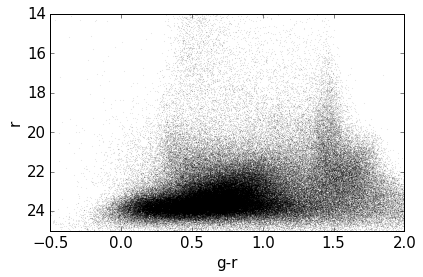

In [101]:
%matplotlib inline 
gr = med_cat_merged['median_mag_g_corr'] - med_cat_merged['median_mag_r_corr']
r = med_cat_merged['median_mag_r_corr']
plt.scatter(gr,r, s=0.001)
plt.xlim(-0.5,2)
plt.ylim(14,25)
plt.xlabel('g-r', fontsize=15)
plt.ylabel('r', fontsize=15)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('Fig_2_Ivezic_2003_200000_sources.png')
plt.show()


In [103]:
med_cat_merged.head()

,objectId,N_u,median_u,sigmaG_u,e_mean_u,e50_u,annAvg_chi2_clip_wm_u,median_mag_u,e50_mag_u,iqrSig_mag_u,N_g,median_g,sigmaG_g,e_mean_g,e50_g,annAvg_chi2_clip_wm_g,median_mag_g,e50_mag_g,iqrSig_mag_g,N_r,median_r,sigmaG_r,e_mean_r,e50_r,annAvg_chi2_clip_wm_r,median_mag_r,e50_mag_r,iqrSig_mag_r,N_i,median_i,sigmaG_i,e_mean_i,e50_i,annAvg_chi2_clip_wm_i,median_mag_i,e50_mag_i,iqrSig_mag_i,N_z,median_z,sigmaG_z,e_mean_z,e50_z,annAvg_chi2_clip_wm_z,median_mag_z,e50_mag_z,iqrSig_mag_z,ebv,median_mag_u_corr,median_mag_g_corr,median_mag_r_corr,median_mag_i_corr,median_mag_z_corr
0,3412884495270282,67,5.572298e-30,1.336731e-29,1.589279e-29,1.025420e-29,3.198440,24.534914,1.997984,2.604559,66,5.550917e-30,8.491647e-30,6.925084e-30,4.581137e-30,13.457120,24.539088,0.896051,1.660931,67,1.026962e-29,7.926279e-30,1.026927e-29,6.740401e-30,12.880008,23.871114,0.712616,0.837991,67,1.962789e-29,1.068462e-29,1.150987e-29,1.019602e-29,6.489706,23.167816,0.564003,0.591030,67,2.826974e-29,3.999308e-29,4.263174e-29,4.078581e-29,1.186833,22.771696,1.566432,1.535986,0.057772,24.832727,24.758216,24.030044,23.288327,22.857140
1,3412884495270287,69,3.142338e-30,1.348610e-29,1.577809e-29,9.953027e-30,2.903886,25.156868,3.438956,4.659699,70,3.810010e-30,5.638115e-30,6.872388e-30,4.461405e-30,8.286238,24.947685,1.271364,1.606690,69,1.059525e-29,6.905020e-30,1.014165e-29,6.447323e-30,1.029124,23.837222,0.660682,0.707584,69,1.137923e-29,1.151897e-29,1.154684e-29,1.006935e-29,3.029758,23.759718,0.960755,1.099069,70,2.156710e-29,4.671885e-29,4.242536e-29,3.876923e-29,3.505116,23.065520,1.951729,2.351931,0.065419,25.494104,25.195820,24.017191,23.896182,23.162275
2,3412884495270291,68,-1.586582e-30,1.453246e-29,1.644718e-29,1.061087e-29,2.124160,NaN,-7.261272,-9.944912,68,1.066642e-29,7.347895e-30,7.054873e-30,4.558287e-30,1.102902,23.829954,0.463989,0.747943,69,1.846765e-29,9.687270e-30,9.741535e-30,6.853575e-30,1.158476,23.233971,0.402930,0.569527,69,2.595336e-29,1.338154e-29,1.161630e-29,1.045984e-29,1.464328,22.864516,0.437578,0.559805,69,4.067690e-29,4.227440e-29,4.393630e-29,4.014247e-29,2.485217,22.376630,1.071471,1.128376,0.077888,NaN,24.125381,23.448240,23.026990,22.491826
3,3412884495270293,63,3.854032e-30,1.374406e-29,1.630198e-29,1.057082e-29,2.738714,24.935212,2.977952,3.871899,63,3.730790e-30,7.967545e-30,6.835850e-30,4.520610e-30,4.490300,24.970498,1.315590,2.318719,63,2.591192e-30,8.172728e-30,9.661778e-30,6.437172e-30,3.383431,25.366251,2.697241,3.424457,63,1.074927e-29,1.195944e-29,1.139159e-29,1.017732e-29,4.675092,23.821553,1.027966,1.207971,63,1.145138e-29,4.737360e-29,4.301436e-29,3.979063e-29,18.672033,23.752855,3.772656,4.491618,0.076416,25.329138,25.260345,25.576472,23.980957,23.865875
4,3412884495270298,69,-2.000005e-30,1.395832e-29,1.607314e-29,1.042555e-29,0.162753,NaN,-5.659687,-7.577508,69,1.819030e-30,7.166494e-30,6.879774e-30,4.593395e-30,1.587758,25.750400,2.741690,4.277512,70,2.072670e-29,9.181623e-30,9.543036e-30,6.596761e-30,1.733494,23.108675,0.345561,0.480965,70,5.900363e-29,1.134468e-29,1.146549e-29,1.031339e-29,5.115755,21.972803,0.189778,0.208755,70,8.877567e-29,4.753881e-29,4.306248e-29,3.953286e-29,5.487140,21.529265,0.483491,0.581405,0.080721,NaN,26.056575,23.330738,22.141187,21.648652


In [247]:
np.median(med_cat_merged['e_mean_u'].values / med_cat_merged['e50_u'].values)

1.368374649263647

In [249]:
np.median(med_cat_merged['e50_u'].values / med_cat_merged['sigmaG_u'].values)

0.74134330247649394

In [251]:
1.36*0.74

1.0064

In [253]:
err = med_cat_merged['e50_u'] / med_cat_merged['median_u']

In [485]:
#err 

In [86]:
ra = np.

NameError: name 'med_cat_merged' is not defined

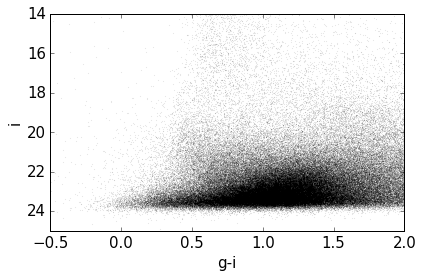

In [226]:
%matplotlib inline 
gi = med_cat_merged['median_mag_g_corr'] - med_cat_merged['median_mag_i_corr']
i = med_cat_merged['median_mag_i_corr']
plt.scatter(gi,i, s=0.001)
plt.xlim(-0.5,2)
plt.ylim(14,25)
plt.xlabel('g-i', fontsize=15)
plt.ylabel('i', fontsize=15)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('Fig_g-i_vs_i_.png')
plt.show()


In [489]:
med_cat_rms = pd.merge(med_cat_merged_ext, fp_rms, how='left', left_on='objectId', right_on='objectId' ,suffixes=('_x', '_y'), copy=True, indicator=False)


In [507]:
np.sum(np.in1d(fp_rms['objectId'], med_cat_merged_ext['objectId']))

0

In [514]:
len(med_cat_merged_ext['objectId'].dropna().values)

200000

In [511]:
len(fp_data['objectId'].values)

2000000

In [490]:
med_cat_rms.columns

Index([u'objectId', u'N_u', u'median_u', u'sigmaG_u', u'e_mean_u', u'e50_u',
       u'annAvg_chi2_clip_wm_u', u'median_mag_u', u'e50_mag_u',
       u'iqrSig_mag_u', u'N_g', u'median_g', u'sigmaG_g', u'e_mean_g',
       u'e50_g', u'annAvg_chi2_clip_wm_g', u'median_mag_g', u'e50_mag_g',
       u'iqrSig_mag_g', u'N_r', u'median_r', u'sigmaG_r', u'e_mean_r',
       u'e50_r', u'annAvg_chi2_clip_wm_r', u'median_mag_r', u'e50_mag_r',
       u'iqrSig_mag_r', u'N_i', u'median_i', u'sigmaG_i', u'e_mean_i',
       u'e50_i', u'annAvg_chi2_clip_wm_i', u'median_mag_i', u'e50_mag_i',
       u'iqrSig_mag_i', u'N_z', u'median_z', u'sigmaG_z', u'e_mean_z',
       u'e50_z', u'annAvg_chi2_clip_wm_z', u'median_mag_z', u'e50_mag_z',
       u'iqrSig_mag_z', u'ebv', u'median_mag_u_corr', u'median_mag_g_corr',
       u'median_mag_r_corr', u'median_mag_i_corr', u'median_mag_z_corr',
       u'deepSourceId', u'extendedness', u'rmsClipped', u'rmsClippedIQR',
       u'rmsMedian', u'rmsMedianIQR'],
      dtype='obje

In [496]:
med_cat_rms['rmsClipped'].dropna()

Series([], Name: rmsClipped, dtype: float64)

In [ ]:
# magnitude bins :

# brightest objects
maskMag = med_cat_rms['median_mag_g_corr'] < 21 
plt.scatter(med_cat_rms[''])


In [105]:
ext = np.random.randint(low=0,high=2,size=N)

In [137]:
N = 1000
ra = 360 * np.random.random_sample(N) 
i = 10*np.random.random_sample(N)+15
ext = np.random.randint(low=0,high=2,size=N)

med_cat_merged_all = OrderedDict({'ra':ra, 'median_mag_i_corr':i, 'extendedness':ext})

In [110]:
med_cat_merged_all['median_mag_i_corr']

array([ 19.76385562,  17.90675626,  22.97132201, ...,  17.35189713,
        16.6956985 ,  22.13456735])

ext = 0
j=0
j=1
j=2
j=3
j=4
ext = 1
j=0
j=1
j=2
j=3
j=4


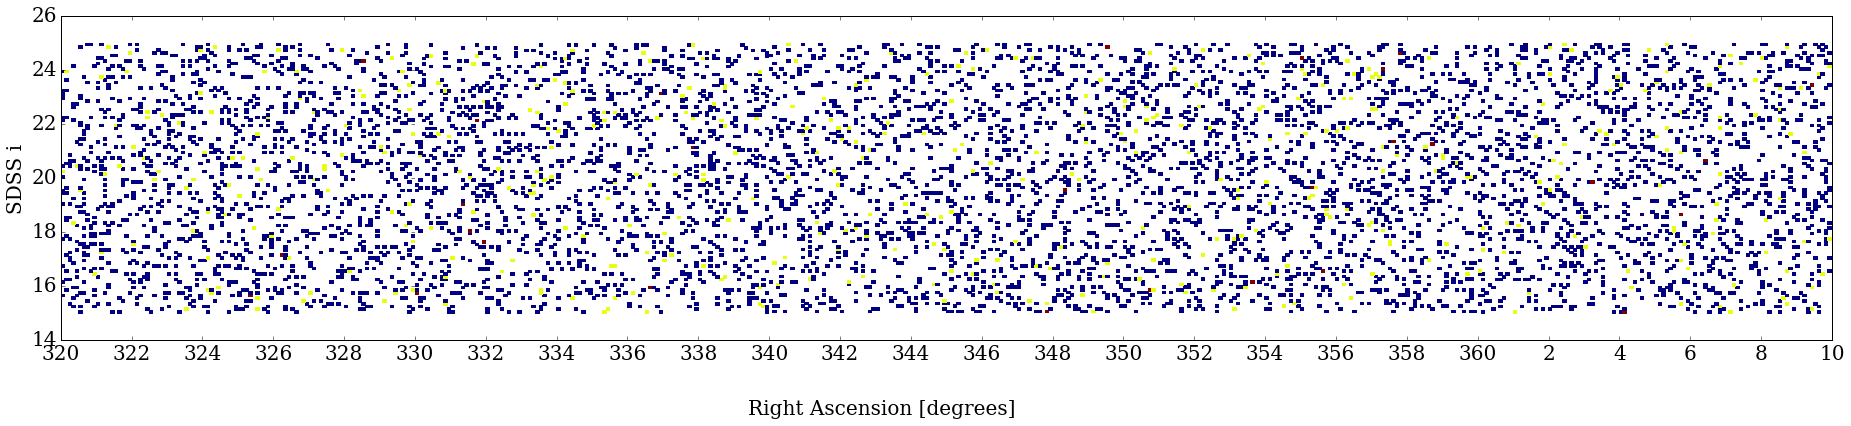

In [146]:
# Make a fake RA - i  dataset to play with how to make the plot I want 
%matplotlib inline 

N = 100000
ra = 360 * np.random.random_sample(N) 
i = 10*np.random.random_sample(N)+15
ext = np.random.randint(low=0,high=2,size=N)

med_cat_merged_dict = OrderedDict({'ra':ra, 'median_mag_i_corr':i, 'extendedness':ext})
med_cat_merged_all = pd.DataFrame(med_cat_merged_dict)
raMin = [320, 330, 340,350,0]
raMax = [330, 340, 350,360,10]

nbins = 100
ylim = [12,26]

for i in range(2):
    print('ext = %d'% i)
    ext=i # choose extendedness 
    fig, axs = plt.subplots(1,5, figsize=(30,6))
    ax = np.ravel(axs) 
    
    for j in range(len(raMin)):
        print('j=%d'%j)
        maskRa =  (raMin[j] < med_cat_merged_all['ra'] )  & (med_cat_merged_all['ra']  < raMax[j])
        maskExtend = med_cat_merged_all['extendedness'] == ext
        maskTot = maskRa * maskExtend
        ra = med_cat_merged_all['ra'][maskTot]
        iBand = med_cat_merged_all['median_mag_i_corr'][maskTot]
        rai = pd.concat([ra,iBand], axis=1)
        rai_dropna = rai.dropna()
        ra = rai_dropna['ra'] 
        iBand = rai_dropna['median_mag_i_corr']
        #H, xedges, yedges = np.histogram2d(i[maskCol],ra[maskCol],bins=nbins)
        H, xedges, yedges = np.histogram2d(ra, iBand,bins=nbins)
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        # Mask zeros
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
        # Plot 2D histogram using pcolor
        ax[j].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
        #ax[j].set_xlabel('RA', fontsize=15)
        if j == 0 : 
            ax[j].set_ylabel('SDSS i', fontsize=20)
        ax[j].set_ylim(ylim[0],ylim[1])
        #ax[j].set_title(str(raMin[j])+'< RA <' + str(raMax[j]), fontsize=20)
        #ax[j].invert_yaxis()
        ax[j].tick_params(axis = 'both', labelsize=20) 
        if j != 0 : 
            ax[j].set_yticks([])
            xticks = ax[j].xaxis.get_major_ticks()
            xticks[0].label1.set_visible(False)
            ax[j].spines['left'].set_visible(False)
        #xticks[-1].label1.set_visible(False)
    #ax[j+1].axis('off')
    fig.subplots_adjust(wspace=0, hspace=0, left=0.12, right=0.94, bottom=0.20, top=0.95)
    fig.text(0.5, 0.04, 'Right Ascension [degrees]', ha='center', va='center',fontsize=20)
    #plt.tight_layout()
    plt.savefig('test_Fig_RA_vs_i_extendedness_'+str(ext)+'.png')
plt.close(fig)
plt.show()

In [158]:
# use a small portion of data to play with plotting color-color diagrams... 

# A MINIMUM NEEDED TO MAKE A  PLOT LIKE THAT OF SESAR+2010, FIG.23 

# DIR with all DATA 
DirIn =  '/astro/users/suberlak/S13Agg/'

# EXTENDEDNESS INFO , take only necessary columns 
deep_src_ext =  pd.read_csv(DirIn+'DeepSourceNCSA_i_lt300.csv', usecols=['deepSourceId', 'extendedness', 'ra', 'decl'], 
                            nrows=200000)

# COADD PHOTOMETRY - ONLY FOR E(B-V)  correction  
med_coadd_ebv = pd.read_csv(DirIn+'medianPhotometry.csv', usecols=['objectId','ebv'],nrows=200000)
# There are  12373162  : 12.3 mln values of objectId 

# CATALOG PHOTOMETRY - USE FOR COLORS 
med_cat_phot = pd.read_csv(DirIn+'lightcurveMetrics/metricsFiles/ugrizMetrics.csv',nrows=200000)
# There are 5892054  : 5.8 mln values of objectId here 



# MERGE CATALOG and COADD for ebv 
med_cat_merged = pd.merge(med_cat_phot, med_coadd_ebv, how='left', on='objectId', suffixes=('_x', '_y'), copy=True, 
                          indicator=False)
# Since it was a left-join ,  it has the same objects as in med_cat_phot : 5892054 : 5.8 mln values of objectId

# CORRECT FOR EXTINCTION using the ebv 
A = [5.155, 3.793, 2.751, 2.086, 1.479]
filters = ['u','g','r','i','z']

for i in range(len(filters)):
    label = 'median_mag_'+filters[i]
    med_cat_merged[label+'_corr'] = med_cat_merged[label] +  med_cat_merged['ebv'] * A[i]

# MERGE with EXTENDEDNESS information


# Only add extendedness 
med_cat_merged_all = pd.merge(med_cat_merged, deep_src_ext, how='left', left_on='objectId', right_on='deepSourceId' ,
                              suffixes=('_x', '_y'), copy=True, indicator=False)
# len(med_cat_merged_all['objectId'].values) = 5892054
# Since it was a left-join, it has the same objects as med_cat_merged: 5892054 : 5.8 mln values of objectId 


print('Number of point sources is %d'%np.sum(med_cat_merged_all['extendedness'] == 0))
# 1908043
print('Number of extended sources is %d'%np.sum(med_cat_merged_all['extendedness'] == 1))
# 3984011  


# How many points we have from NCSA ...

#For 310<ra<320,  we have 24970 points
#For 320<ra<330,  we have 1419807 points
#For 330<ra<340,  we have 1225997 points
#For 340<ra<350,  we have 1125263 points
#For 350<ra<360,  we have 1046624 points
#For 0<ra<10,  we have 1049393 points


#   DO THE 3 PANEL PLOTS 

# in the ipython, use 
# %cpaste   magick !!!! 
# http://stackoverflow.com/questions/10886946/how-does-ipythons-magic-paste-work

raMin = [320, 330, 340,350,0]
raMax = [330, 340, 350,360,10]

(array([ 25725.,  11182.,   9216.,   8324.,   6828.,   6166.,   6452.,
          6959.,   6345.,  12803.]),
 array([ 22.        ,  22.2       ,  22.4       ,  22.6       ,
         22.8       ,  22.99999999,  23.19999999,  23.39999999,
         23.59999999,  23.79999999,  23.99999999]),
 <a list of 10 Patch objects>)

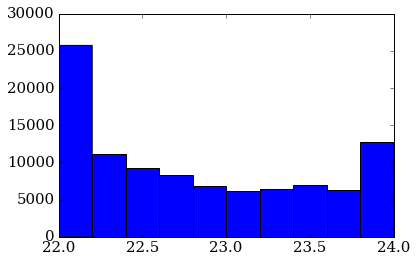

In [164]:
plt.hist(r+23)

In [186]:
mag_lims = [5,23,23.5,24.5,35]
for k in range(len(mag_lims)-1):
    print 'lo',mag_lims[k],' hi', mag_lims[k+1]

 lo 5  hi 23
lo 23  hi 23.5
lo 23.5  hi 24.5
lo 24.5  hi 35


j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4
j=0
j=1
j=2
j=3
j=4


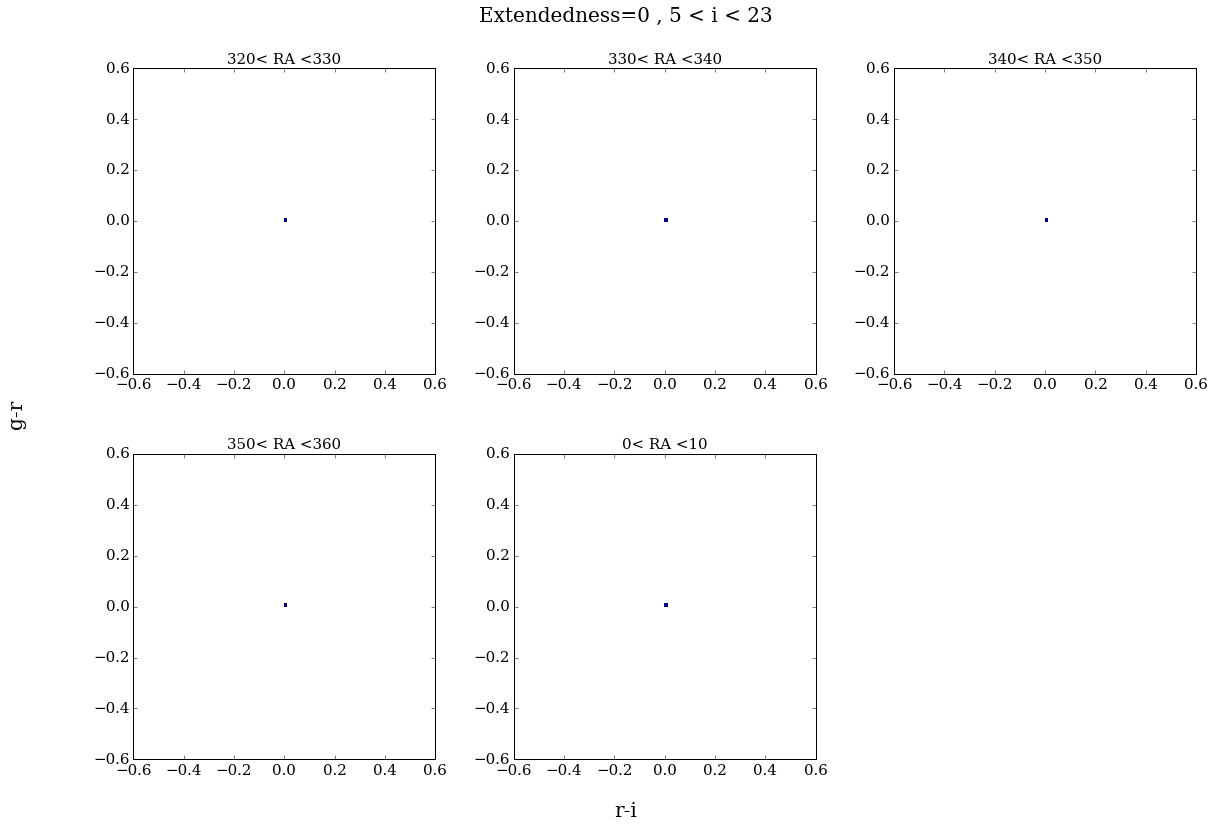

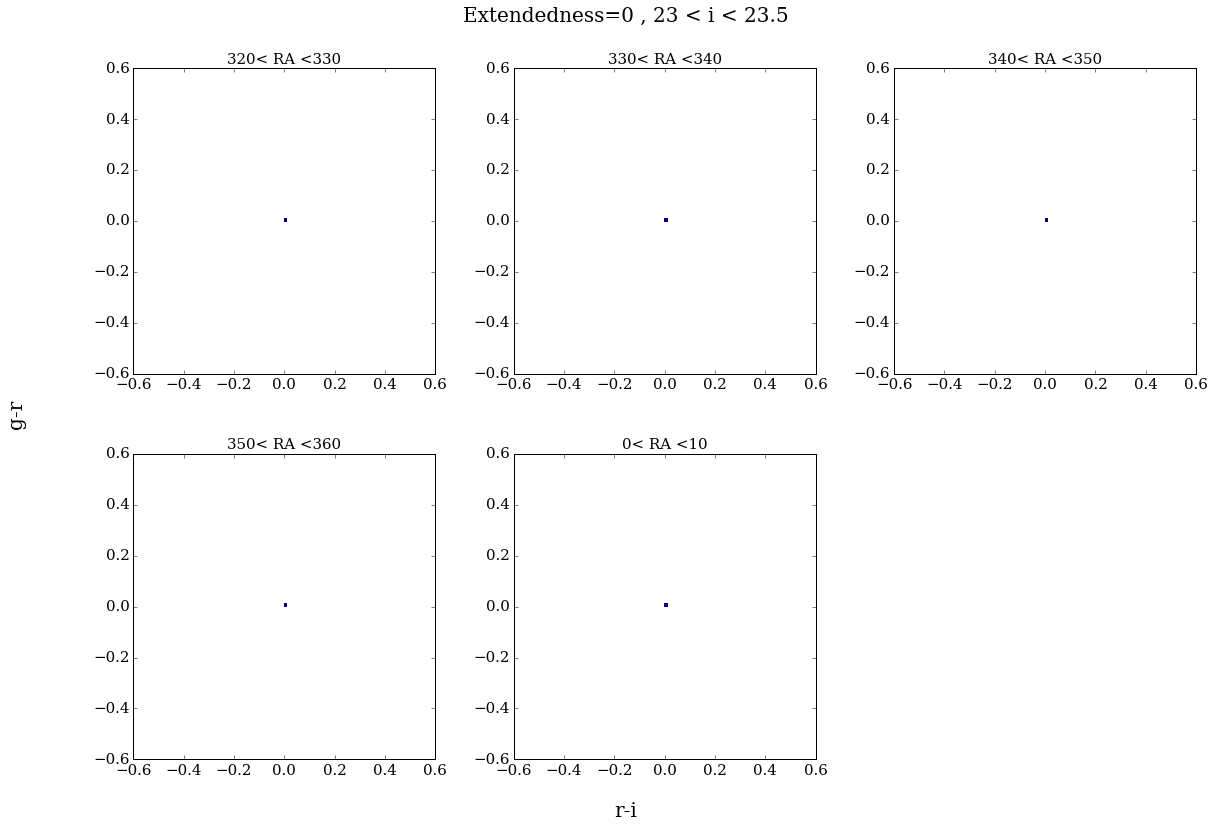

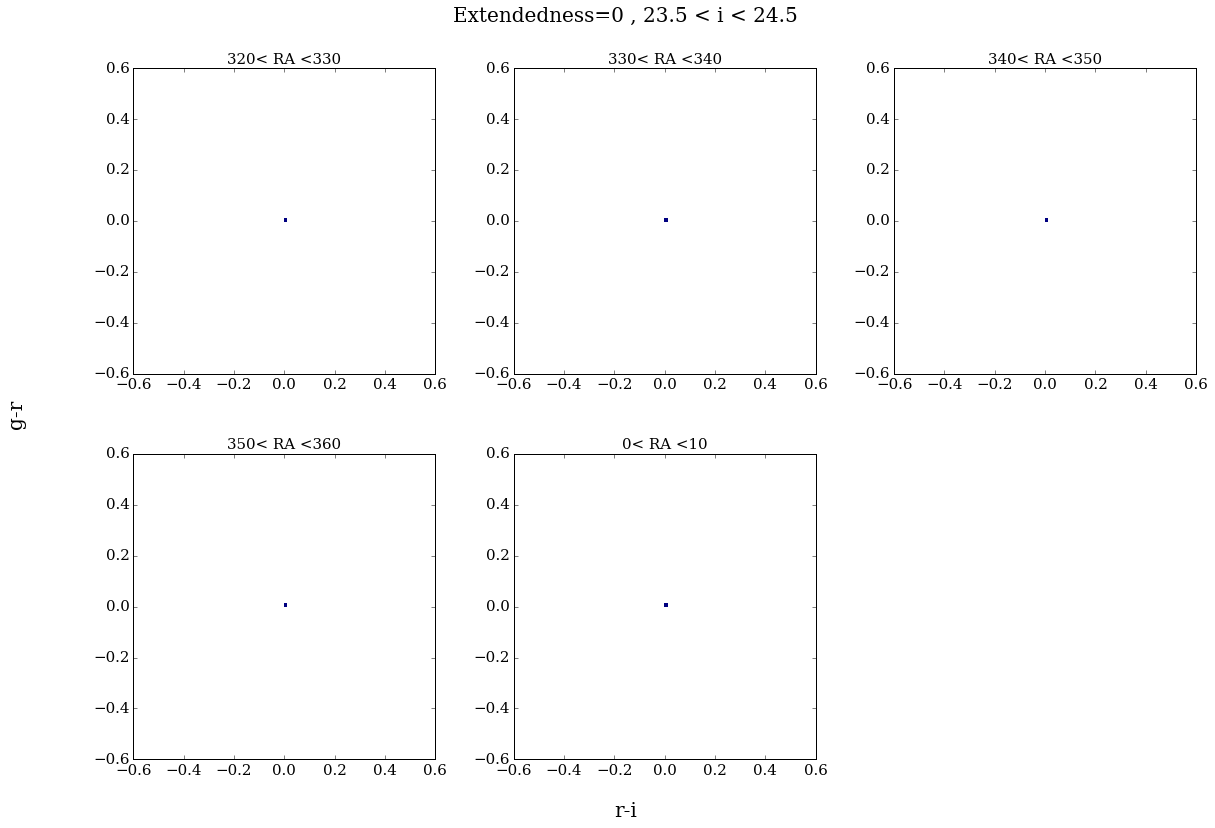

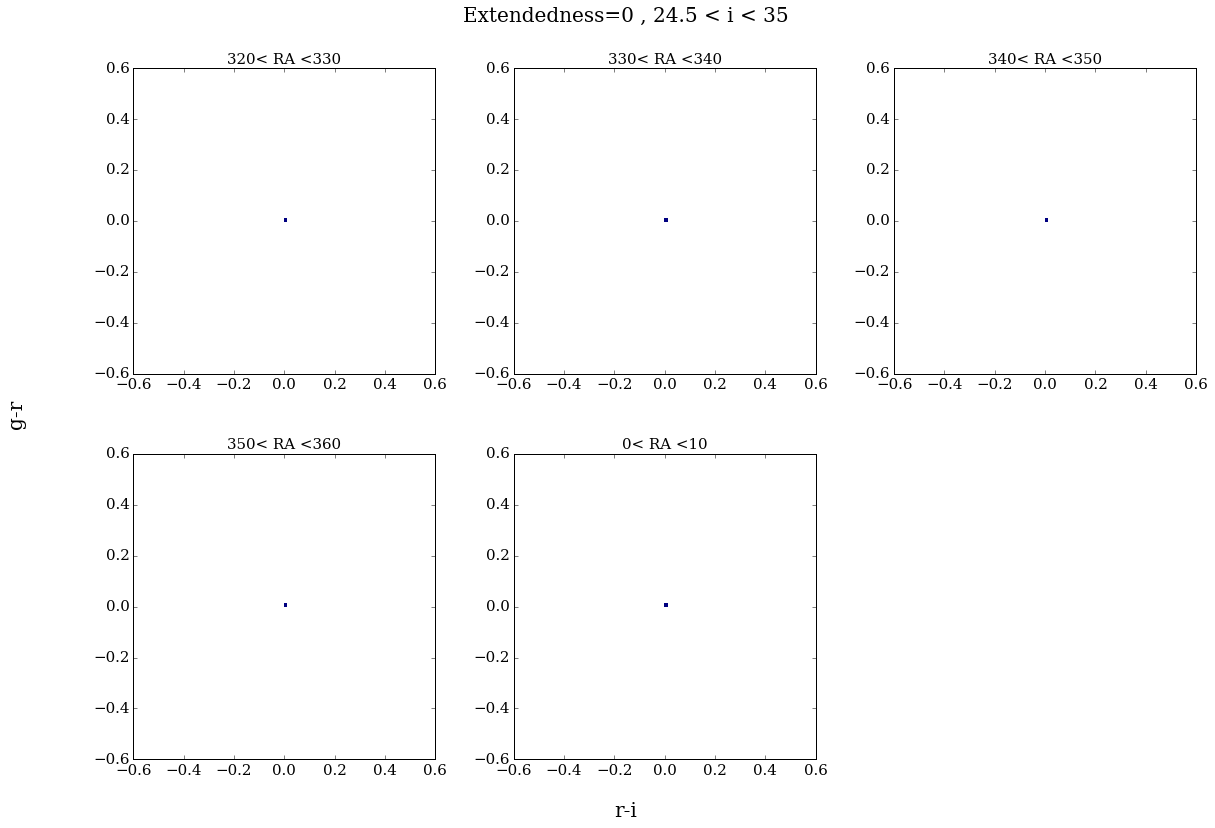

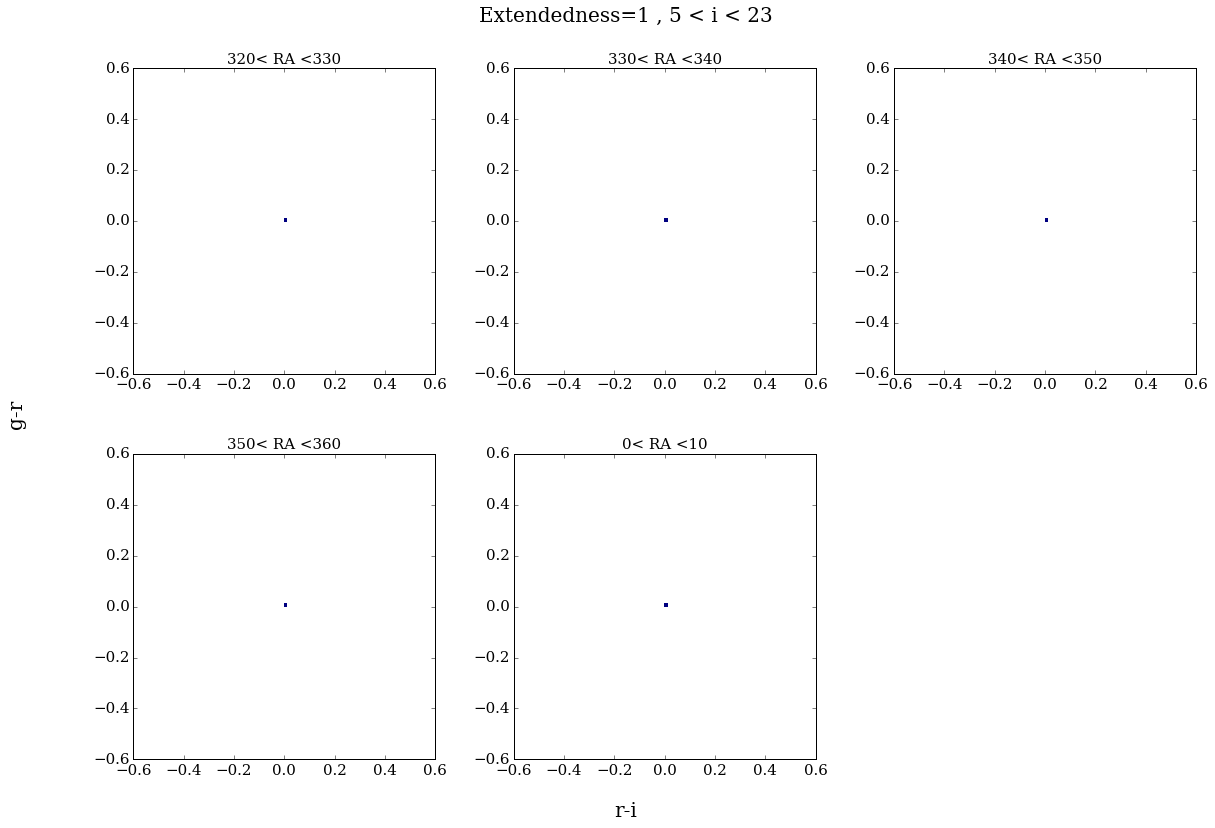

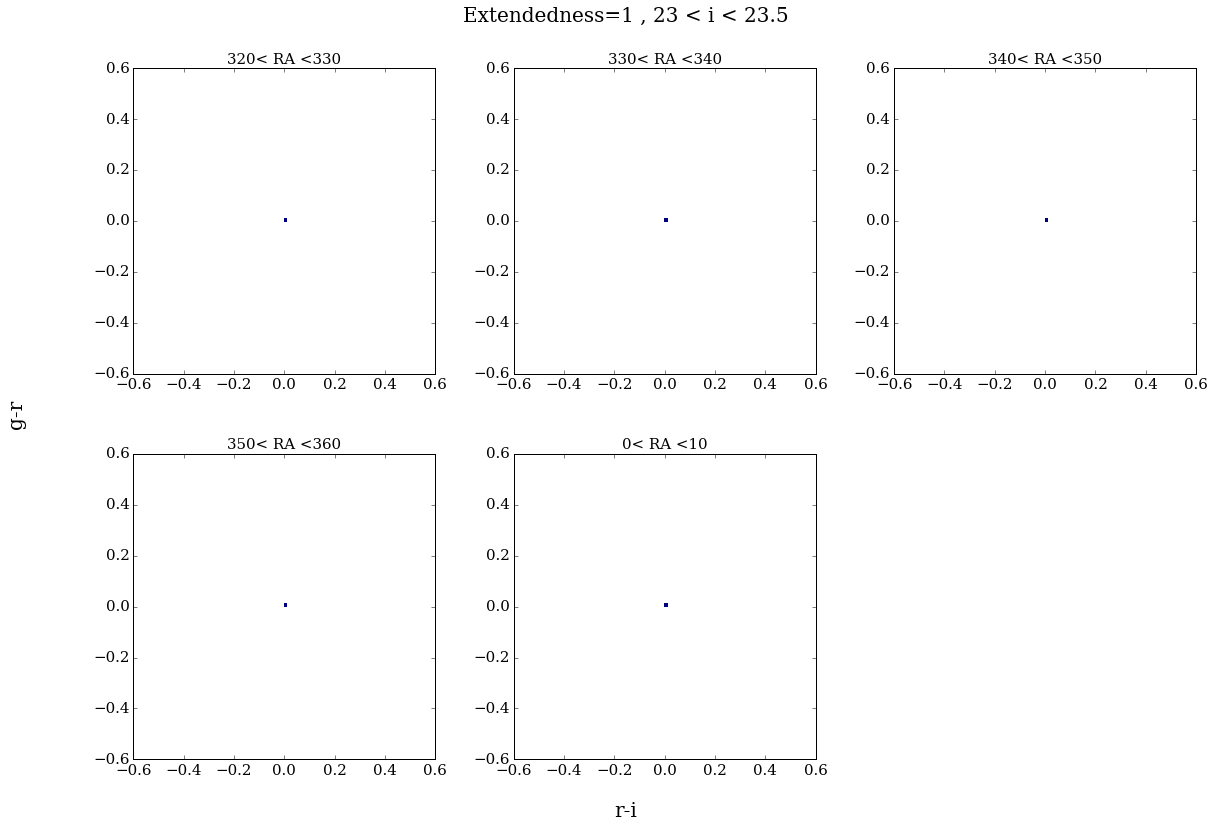

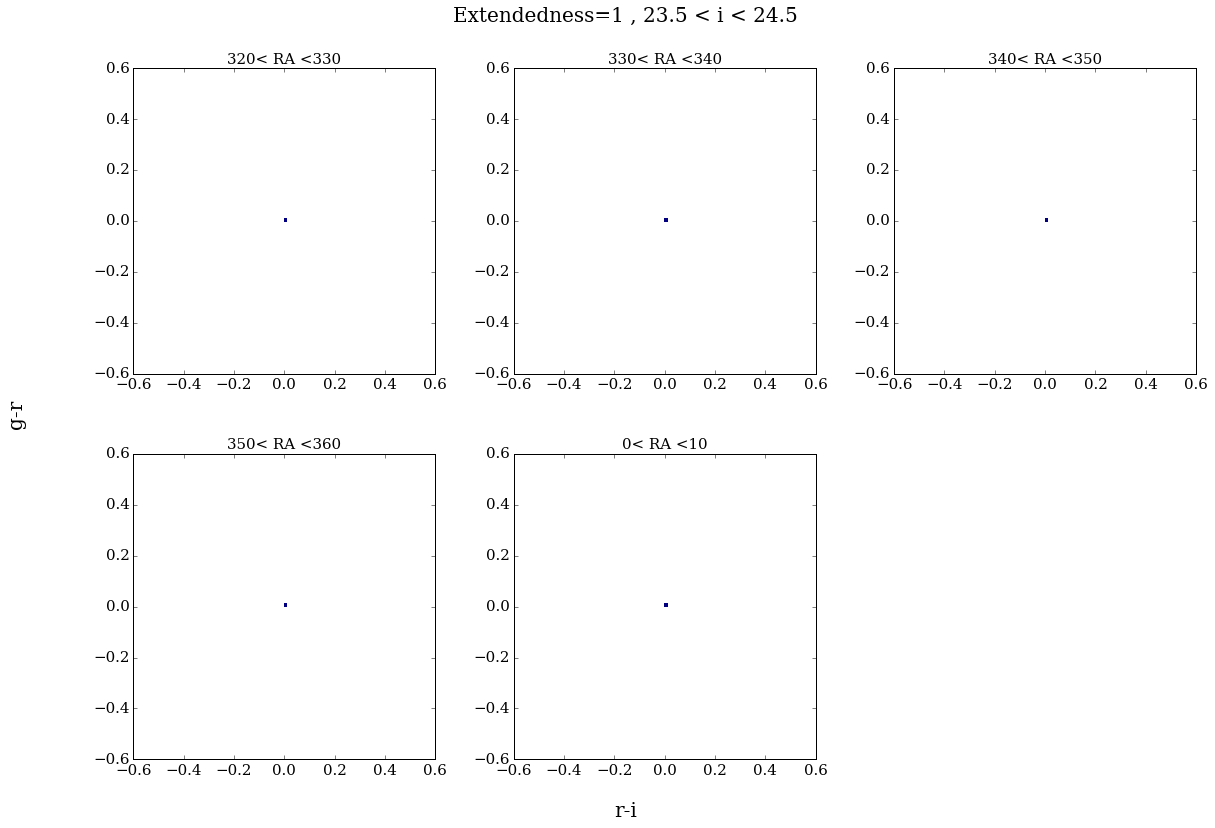

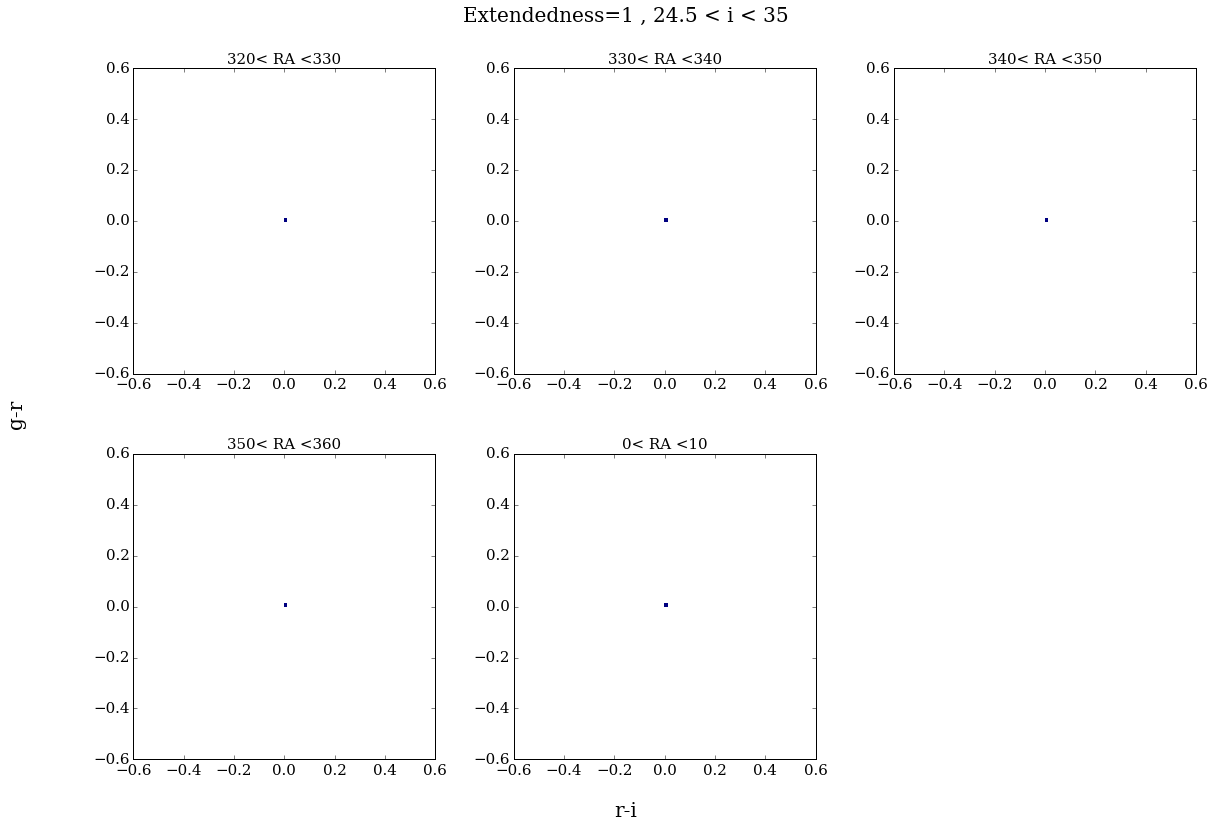

In [189]:
# make a fake g,r,i  dataset to play with .... 
%matplotlib inline 

xlim = [-1,3]
ylim = [-1,3]
#nbinsArr = [100,100,50]
mag_lims = [5,23,23.5,24.5,35]

nbins = 100

for i in range(2):
    ext=i # choose extendedness 
    
    for k in range(len(mag_lims)-1):
        maskIband = (mag_lims[k] < med_cat_merged_all['median_mag_i_corr'])*(med_cat_merged_all['median_mag_i_corr'] < mag_lims[k+1])
        
        # make a plot for each extendedness and mag range 
        fig, axs = plt.subplots(2,3, figsize=(18,12))
        ax = np.ravel(axs) 

        for j in range(len(raMin)):
            print('j=%d'%j)
            maskRa =  (raMin[j] < med_cat_merged_all['ra'])  & (med_cat_merged_all['ra'] < raMax[j])
            maskExtend = med_cat_merged_all['extendedness'] == ext

            maskTot = maskRa * maskExtend * maskIband
            ri = med_cat_merged_all['median_mag_r_corr'][maskTot] - med_cat_merged_all['median_mag_i_corr'][maskTot]
            gr = med_cat_merged_all['median_mag_g_corr'][maskTot] - med_cat_merged_all['median_mag_r_corr'][maskTot]
            grri = pd.concat([gr,ri], axis=1)
            grri_dropna = grri.dropna()
            gr = grri_dropna[0]
            ri = grri_dropna[1]
            maskCol = (ri < xlim[1])&(ri>xlim[0])&(gr<ylim[1])&(gr>ylim[0])
            H, xedges, yedges = np.histogram2d(gr[maskCol],ri[maskCol],bins=nbins)
            #H, xedges, yedges = np.histogram2d(grri_dropna[1],grri_dropna[0],bins=nbins)
            # H needs to be rotated and flipped
            H = np.rot90(H)
            H = np.flipud(H)
            # Mask zeros
            Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
            # Plot 2D histogram using pcolor
            ax[j].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
            #ax[j].set_ylabel('r-i', fontsize=15)
            #ax[j].set_xlabel('g-r', fontsize=15)
            #ax[j].set_xlim(xlim[0],xlim[1])
            ax[j].set_title(str(raMin[j])+'< RA <' + str(raMax[j]))
            #ax[j].invert_yaxis()

            ax[j].tick_params(axis = 'both', labelsize=15) 

        #fig.subplots_adjust(wspace=0, hspace=0, left=0.1, bottom=0.20, top=0.95)

        ax[j+1].axis('off')
        fig.text(0.5, 0.96, 'Extendedness='+str(ext)+' , '+str(mag_lims[k])+' < i < '+str(mag_lims[k+1]), ha='center', va='center',fontsize=20)
        fig.text(0.5, 0.04, 'r-i', ha='center', va='center',fontsize=20)
        fig.text(0.03, 0.5, 'g-r', ha='center', va='center', rotation='vertical',fontsize=20)

        fig.tight_layout()
        fig.subplots_adjust(wspace=0.26, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.9)

        plt.savefig('test_Fig_g-r_vs_r-i_ext_'+str(ext)+'_'+str(mag_lims[k])+'-i-'+str(mag_lims[k+1])+'.png')
#plt.close(fig)
plt.show()

